# **COMP4433 Kaggle Competition Report**

# **Load Data**

In [22]:
#read the training and testing data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import scipy.stats as spst
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## **Exploratory Data Analysis**


> The features have been divided into 2 categories: numeric and categorial ones. Among the categorial ones, we observed that some are ordinal ones, which contain rank information. This may lead to diffrent methods in encoding and missing value filling.

> Thus, we divided the features into three groups $[numeric, categorical, ordinal]$ based on the data description file.


#### **Numeric Features**

In [23]:
numeric = [f for f in train.columns if train.dtypes[f] != 'object']
numeric.remove('SalePrice')
numeric.remove('Id')
print(numeric)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']




> While we could get all features of non-object type, some of them are discrete values or integers in a small range, which would better be arranged into categorical or ordinal types.




In [24]:
for s in ['MSSubClass','OverallQual','OverallCond']:
  numeric.remove(s)
train_numeric = train[numeric].copy()
test_numeric = test[numeric].copy()

#### **Categorical Features**

> Since categorical Features are mixed with Ordinal Features and there are some confused features like 'MSSubClass', we manually select the rankless categorical features. Below are the selected ones.

In [25]:
categorical = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', '3SsnPorch', 'PoolArea', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

#### **Ordinal Features**

In [26]:
ordinal = ["MSSubClass", "OverallQual", "OverallCond", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "PoolQC", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]

# **Feature Engineering**

#### **Numeric Features**

###### ***Filling Missing Values***

> We first list the features with missing numeric values in train and test data.

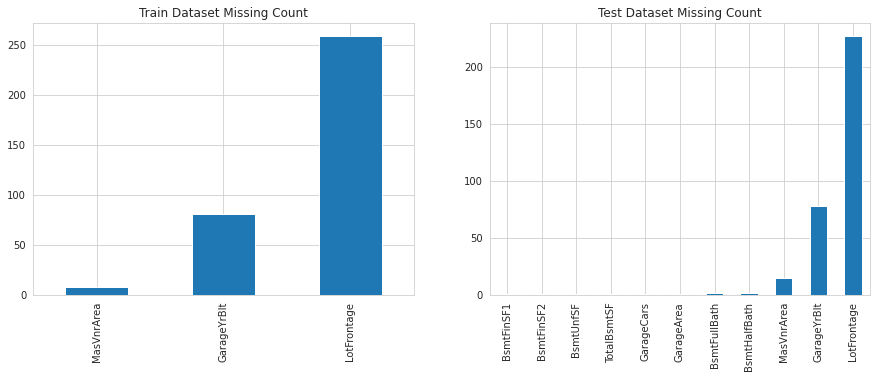

In [27]:
def plot_missing():
  train_numeric_missing = train_numeric.loc[:,train_numeric.isnull().any(axis=0)]
  test_numeric_missing = test_numeric.loc[:,test_numeric.isnull().any(axis=0)]
  fig_count = 2
  train_missing = True
  test_missing = True
  print()
  if train_numeric_missing.isnull().sum().sum()==0:
    print("No missing values in train")
    train_missing = False
    fig_count -= 1
  if test_numeric_missing.isnull().sum().sum()==0:
    print("No missing values in test")
    test_missing = False
    fig_count -= 1
  if fig_count==0:
    return
  else:
    fig, axs = plt.subplots(ncols=fig_count, nrows=1, figsize=(15,5))
    sns.set_style("whitegrid")
  if train_missing:
    missing = train_numeric_missing.isnull().sum()
    missing.sort_values(inplace=True)
    missing.plot.bar(ax=(axs[0]))
    axs[0].set_title("Train Dataset Missing Count")
  if test_missing:
    missing = test_numeric_missing.isnull().sum()
    missing.sort_values(inplace=True)
    ax = axs if hasattr(axs, 'plot') else axs[-1]
    missing.plot.bar(ax=ax)
    ax.set_title("Test Dataset Missing Count")
plot_missing()

> **Basement and Bath Series**: 
The basement area series are missing all at the same time, which possibly indicates that the non-existence of the basement. The basement bath series are in similar situation. Thus, we fill such missings with 0.

In [28]:
display(test[test.BsmtFinSF1.isnull()])
display(test[test.BsmtFullBath.isnull()])
test_numeric[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']] = test_numeric[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']].fillna(0)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
660,2121,20,RM,99.0,5940,Pave,NaN,IR1,Lvl,AllPub,FR3,Gtl,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1946,1950,Gable,CompShg,MetalSd,CBlock,None,0.0,TA,TA,PConc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GasA,TA,Y,FuseA,896,0,0,896,NaN,NaN,1,0,2,1,TA,4,Typ,0,NaN,Detchd,1946.0,Unf,1.0,280.0,TA,TA,Y,0,0,0,0,0,0,NaN,MnPrv,NaN,0,4,2008,ConLD,Abnorml


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
660,2121,20,RM,99.0,5940,Pave,NaN,IR1,Lvl,AllPub,FR3,Gtl,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1946,1950,Gable,CompShg,MetalSd,CBlock,None,0.0,TA,TA,PConc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GasA,TA,Y,FuseA,896,0,0,896,NaN,NaN,1,0,2,1,TA,4,Typ,0,NaN,Detchd,1946.0,Unf,1.0,280.0,TA,TA,Y,0,0,0,0,0,0,NaN,MnPrv,NaN,0,4,2008,ConLD,Abnorml
728,2189,20,RL,123.0,47007,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1959,1996,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,TA,Y,SBrkr,3820,0,0,3820,NaN,NaN,3,1,5,1,Ex,11,Typ,2,Gd,Attchd,1959.0,Unf,2.0,624.0,TA,TA,Y,0,372,0,0,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal


> **MaxVnrArea**: Originally a solution would be to set the value to be the grouped mean of each MaxVnrType. But MasVnrType seems to miss along with MasVnrArea for all entries. We have to use other methods.

In [29]:
display(train[train.MasVnrArea.isnull()][['MasVnrType', 'MasVnrArea']])
display(test[test.MasVnrArea.isnull()][['MasVnrType', 'MasVnrArea']])

,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


,MasVnrType,MasVnrArea
231,NaN,NaN
246,NaN,NaN
422,NaN,NaN
532,NaN,NaN
544,NaN,NaN
581,NaN,NaN
851,NaN,NaN
865,NaN,NaN
880,NaN,NaN
889,NaN,NaN


> When the missing It would be arbitrary to use the universal average/median value as fillers, a better idea is to find the most correlated qualitative features and use them to group the values in current feature. Median or mean of the group that the missing value belongs to can be used as filler. Here we use median.

> First we calculate the correlations between the features with missing values and some categorical features. As categorical data cannot be directly put into correlation calculation, we frist play a trick by replacing the category labels with mean SalePrice in the corresponding groups.


In [30]:
def cat_2_price_mean(df, feature):
  price_mean = pd.DataFrame()
  price_mean['val'] = df[feature].unique()
  price_mean.index = price_mean.val
  price_mean['price_mean'] = df[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
  price_mean = price_mean.sort_values('price_mean')
  for _, row in price_mean.iterrows():
    df.loc[df[feature] == row.val, feature+'_Mean'] = row.price_mean

> Before pushing into correlation, the numeric LotArea feature is seemingly to help filling LotFrontage because of the common field 'Lot' they are about. We thus apply a discretization method, which devides LotArea into 10 intervals in ascending order and formulate the intervals as a new feature LotAreaItv.

In [31]:
_,bins = pd.qcut(train.LotArea,10, retbins=True)
bins = np.concatenate(([-np.inf], bins[1:-1], [np.inf]))
train["LotAreaItv"] = pd.cut(train.LotArea, bins)
test["LotAreaItv"] = pd.cut(test.LotArea, bins)

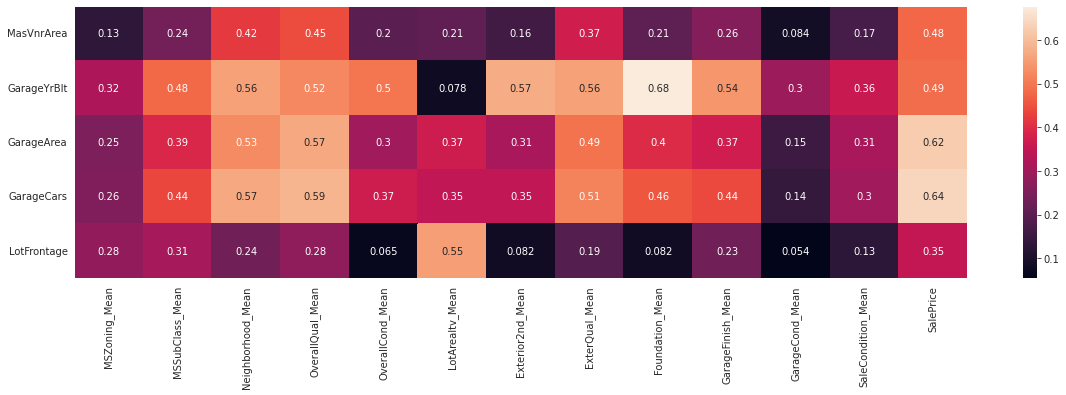

In [32]:
selected_cat = ['MSZoning', 'MSSubClass', 'Neighborhood', 'OverallQual', 'OverallCond', 'LotAreaItv','Exterior2nd','ExterQual','Foundation','GarageFinish','GarageCond','SaleCondition']
selected_cat_mean = [(s+'_Mean') for s in selected_cat]
df_selected_cat = train[selected_cat+['SalePrice']].copy()
for c in selected_cat:  
  cat_2_price_mean(df_selected_cat, c)
missing_cols = ['MasVnrArea', 'GarageYrBlt', 'GarageArea', 'GarageCars', 'LotFrontage']
corr = pd.DataFrame(np.zeros([len(missing_cols), len(selected_cat_mean)+1]), index=missing_cols, columns=selected_cat_mean+['SalePrice'])
for q1 in missing_cols:
    for q2 in selected_cat_mean+['SalePrice']:
        corr.loc[q1, q2] = train[q1].corr(df_selected_cat[q2])
fig, ax = plt.subplots(figsize=(20,5)) 
sns.heatmap(corr, annot=corr, ax=ax)

In [33]:
GarageArea_median_by_OverallQual = train.groupby(['OverallQual'])['GarageArea'].median().to_dict()
print(GarageArea_median_by_OverallQual)
train_numeric.GarageArea = train_numeric.GarageArea.fillna(train.OverallQual.map(GarageArea_median_by_OverallQual))
test_numeric.GarageArea = test_numeric.GarageArea.fillna(test.OverallQual.map(GarageArea_median_by_OverallQual))

{1: 0.0, 2: 246.0, 3: 297.5, 4: 300.5, 5: 352.0, 6: 440.0, 7: 527.0, 8: 676.0, 9: 746.0, 10: 841.0}


In [34]:
GarageCars_median_by_OverallQual = train.groupby(['OverallQual'])['GarageArea'].median().to_dict()
print(GarageCars_median_by_OverallQual)
train_numeric.GarageCars = train_numeric.GarageCars.fillna(train.OverallQual.map(GarageCars_median_by_OverallQual))
test_numeric.GarageCars = test_numeric.GarageCars.fillna(test.OverallQual.map(GarageCars_median_by_OverallQual))

{1: 0.0, 2: 246.0, 3: 297.5, 4: 300.5, 5: 352.0, 6: 440.0, 7: 527.0, 8: 676.0, 9: 746.0, 10: 841.0}


In [35]:
GarageYrBlt_median_by_Foundation = train.groupby(['Foundation'])['GarageYrBlt'].median().to_dict()
print(GarageYrBlt_median_by_Foundation)
train_numeric.GarageYrBlt = train_numeric.GarageYrBlt.fillna(train.Foundation.map(GarageYrBlt_median_by_Foundation))
test_numeric.GarageYrBlt = test_numeric.GarageYrBlt.fillna(test.Foundation.map(GarageYrBlt_median_by_Foundation))

{'BrkTil': 1937.0, 'CBlock': 1967.0, 'PConc': 2002.0, 'Slab': 1964.5, 'Stone': 1951.5, 'Wood': 1990.0}


In [36]:
MasVnrArea_median_by_Neighborhood_OverallQual = train.groupby(['OverallQual'])['MasVnrArea'].median().to_dict()
print(MasVnrArea_median_by_Neighborhood_OverallQual)
train_numeric.MasVnrArea = train_numeric.MasVnrArea.fillna(train.OverallQual.map(MasVnrArea_median_by_Neighborhood_OverallQual))
test_numeric.MasVnrArea = test_numeric.MasVnrArea.fillna(test.OverallQual.map(MasVnrArea_median_by_Neighborhood_OverallQual))

{1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 14.0, 8: 176.0, 9: 300.0, 10: 420.0}


In [37]:
LotFrontage_median_by_LotAreaItv = train.groupby(['LotAreaItv'])['LotFrontage'].median().to_dict()
print(LotFrontage_median_by_LotAreaItv)
#train['LotFrontage'].fillna(train.LotAreaItv.map(LotFrontage_median_by_LotAreaItv), inplace=True) #This could introduce 'cetegory' data type.
train_numeric.loc[train_numeric['LotFrontage'].isna(), 'LotFrontage'] = train.loc[train['LotFrontage'].isna(), 'LotAreaItv'].map(LotFrontage_median_by_LotAreaItv).astype(float)
test_numeric.loc[test_numeric['LotFrontage'].isna(), 'LotFrontage'] = test.loc[test['LotFrontage'].isna(), 'LotAreaItv'].map(LotFrontage_median_by_LotAreaItv).astype(float)

{Interval(-inf, 5000.0, closed='right'): 35.0, Interval(5000.0, 7078.4, closed='right'): 52.0, Interval(7078.4, 8063.7, closed='right'): 61.0, Interval(8063.7, 8793.4, closed='right'): 65.0, Interval(8793.4, 9478.5, closed='right'): 70.5, Interval(9478.5, 10198.2, closed='right'): 76.0, Interval(10198.2, 11066.5, closed='right'): 75.0, Interval(11066.5, 12205.8, closed='right'): 84.5, Interval(12205.8, 14381.7, closed='right'): 85.0, Interval(14381.7, inf, closed='right'): 90.0}


In [38]:
plot_missing()


No missing values in train
No missing values in test


###### ***New Feature Construction***
> By utilizing existing numeric features, we may derive new features that could reveal addtional information based on the real-word meanings of the features. There are several types of combination, including summation, multiplication and existence extraction.

> With summation, we could derive:
  
> * **The overall living area of the house:** Total House Area = Basement Area + 1st Floor Area + 2nd Floor Area
* **The overall property area of the house:** Total Property Area = Basement Area + 1st Floor Area + 2nd Floor Area + Garage Area
* **The bathroom number in the house:** Total Bathrooms=Full Bathroom + 0.5 * Half Bathrooms + Basement Full Bathrooms + 0.5 * Basement Half Bathrooms
* **The overall porch and wood deck area of the house:** Total Porch Area = Open Porch + Eclosed Porch + 3 Season Porch + Screen Porch + Wood Deck Area

In [39]:
train_numeric['TotalHouseSF'] = train_numeric['TotalBsmtSF'] + train_numeric['1stFlrSF'] + train_numeric['2ndFlrSF']
test_numeric["TotalHouseSF"] = test_numeric["TotalBsmtSF"] + test_numeric["1stFlrSF"] + test_numeric["2ndFlrSF"]

train_numeric['TotalPropertySF'] = train_numeric['TotalHouseSF'] + train_numeric['GarageArea']
test_numeric["TotalPropertySF"] = test_numeric["TotalHouseSF"] + test_numeric["GarageArea"]

train_numeric['TotalBath'] = train_numeric['FullBath'] + (0.5 * train_numeric['HalfBath']) + train_numeric['BsmtFullBath'] + (0.5 * train_numeric['BsmtHalfBath'])
test_numeric['TotalBath'] = test_numeric['FullBath'] + (0.5 * test_numeric['HalfBath']) + test_numeric['BsmtFullBath'] + (0.5 * test_numeric['BsmtHalfBath'])

train_numeric['TotalPorchSF'] = train_numeric['OpenPorchSF'] + train_numeric['EnclosedPorch'] + train_numeric['3SsnPorch'] + train_numeric['ScreenPorch'] + train_numeric['WoodDeckSF']
test_numeric['TotalPorchSF'] = test_numeric['OpenPorchSF'] + test_numeric['EnclosedPorch'] + test_numeric['3SsnPorch'] + test_numeric['ScreenPorch']

> The correlation of the summation features to SalePrice are numerically better than the original component feature.

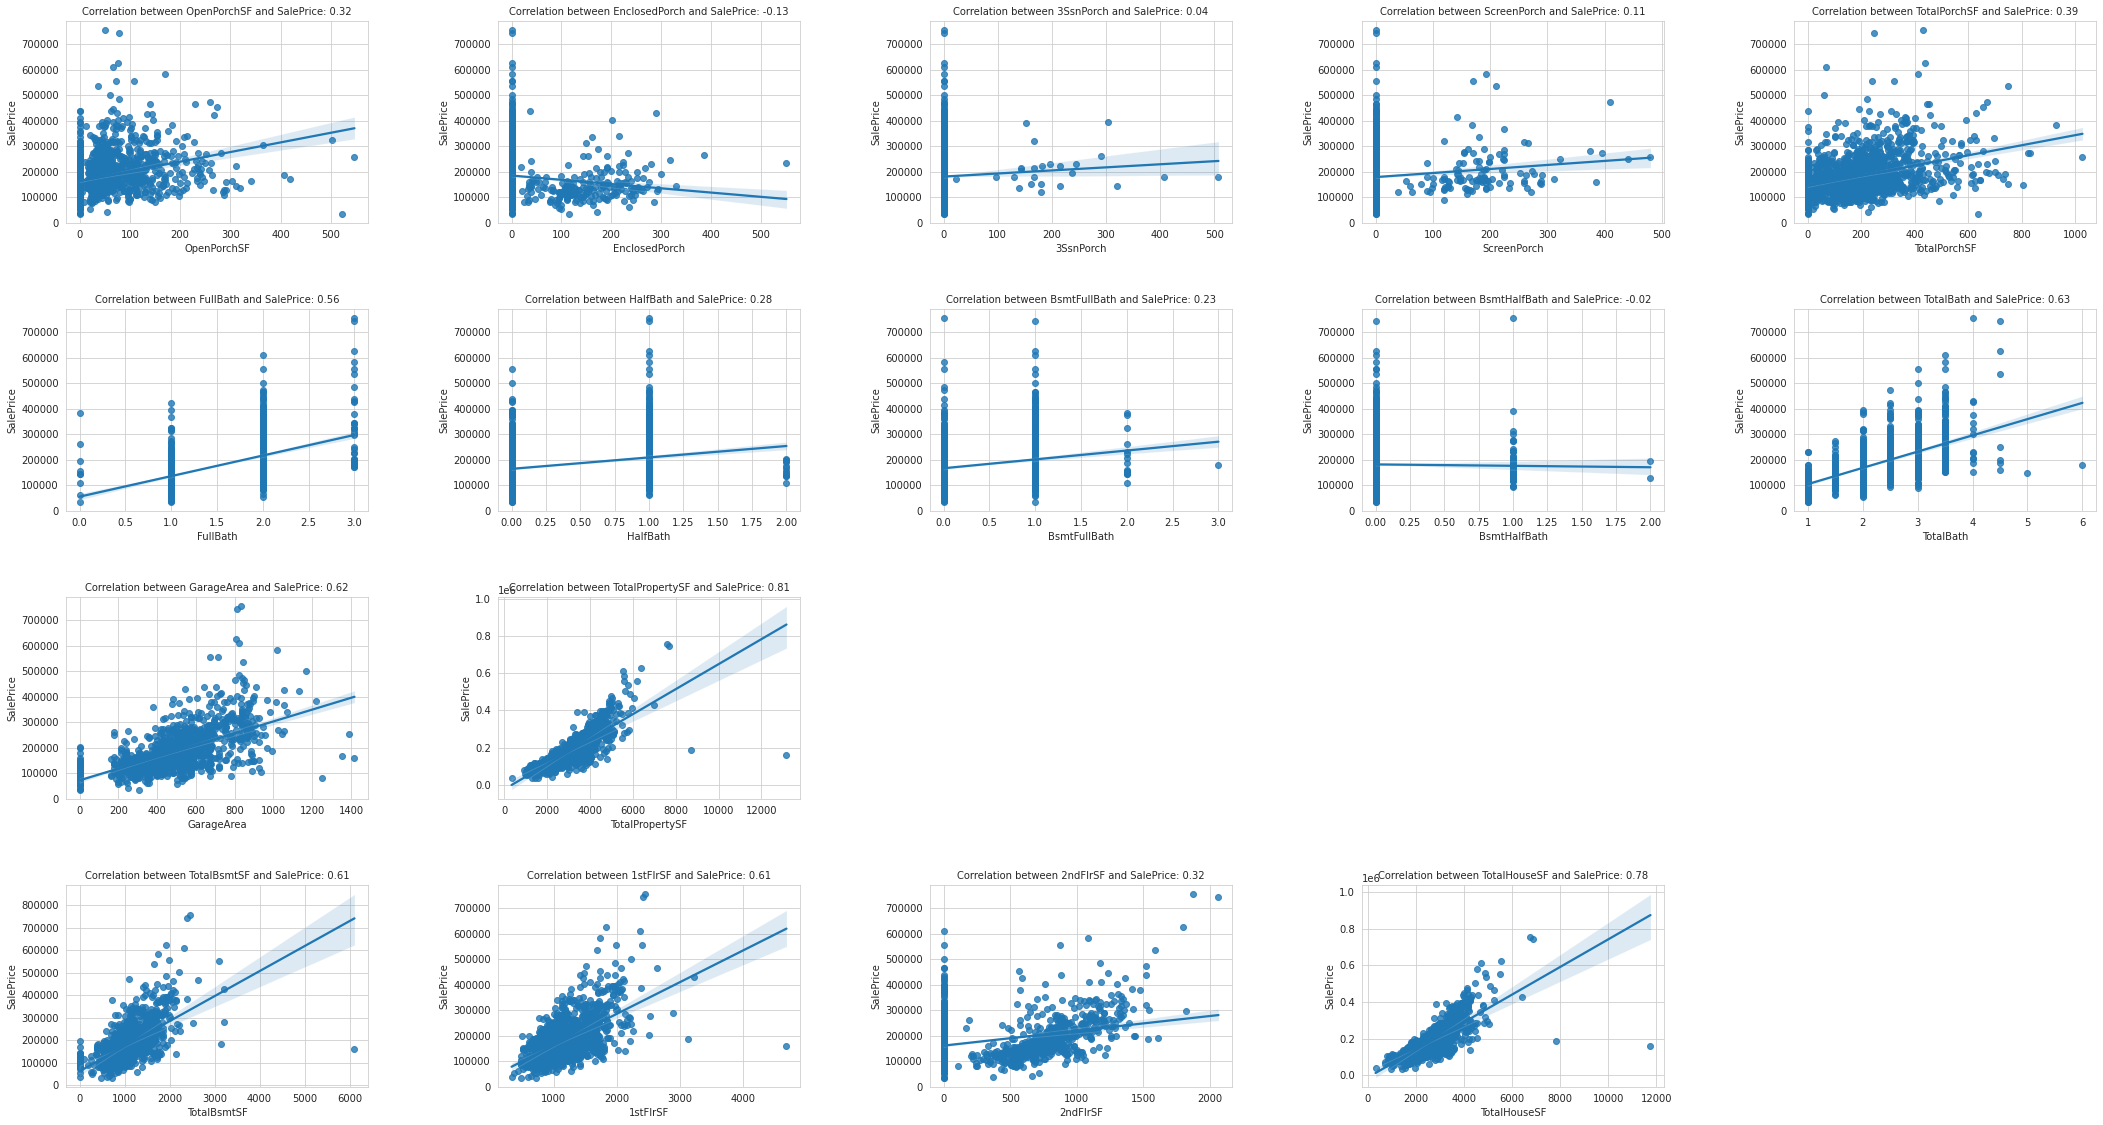

In [40]:
fig = plt.figure()
house_sf = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF' , 'TotalHouseSF']
prop_sf = ['GarageArea','TotalPropertySF']
bath_cnt = ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath', 'TotalBath']
porch_sf = ['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'TotalPorchSF']
new_sum = [house_sf, prop_sf, bath_cnt, porch_sf]
plt.subplots_adjust(left=None, bottom=10, right=None, top=11, wspace=None, hspace=None)
for j, l in enumerate(new_sum):
  for i, v in enumerate(l):
    ax = fig.add_axes([i, j, .7, .7])
    ax.set_title("Correlation between %s and SalePrice: %.2f"% (v, train_numeric[v].corr(train.SalePrice)), y=1, fontsize=10)
    sns.regplot(x=train_numeric[v], y=train.SalePrice, ax=ax)


> With multiplication, we process the GarageArea and GarageCars. This idea was inspired from the physics fomular $P=U*I$ and $R=U/I$. Here the $U$ could be GarageArea, $I$ could be GarageCars, and $R$ could be the Average area for each car. This $P$ feature surprisingly outperforms the 'Average area for each car' one.
  
>* **Garage Utilization Power:** Garage Utilization Power = Garage Total Area $*$ Garage Car Capacity 

In [41]:
train_numeric['GarageUtilPow'] = train_numeric.GarageArea*train_numeric.GarageCars
test_numeric['GarageUtilPow'] = test_numeric.GarageArea*test_numeric.GarageCars

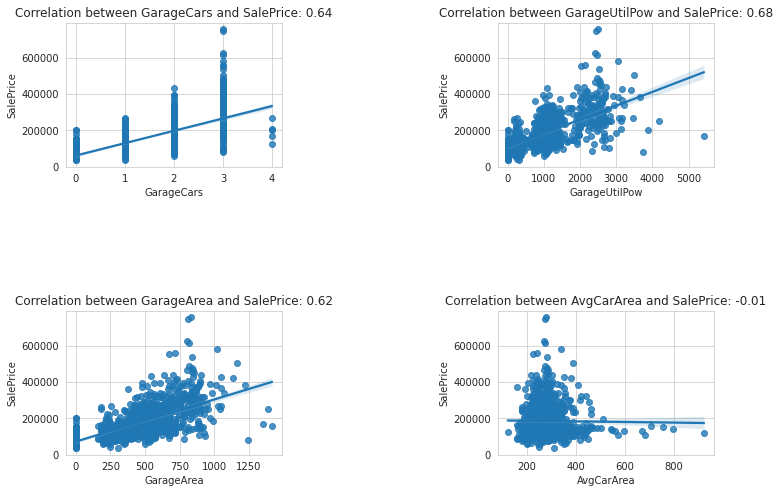

In [42]:
train_numeric['AvgCarArea'] = train_numeric.GarageArea/train_numeric.GarageCars
fig = plt.figure()
plt.subplots_adjust(left=None, bottom=10, right=None, top=11, wspace=None, hspace=None)
new_mul = ['GarageArea', 'GarageCars', 'AvgCarArea', 'GarageUtilPow']
for i, v in enumerate(new_mul):
  ax = fig.add_axes([i//2, i%2, .5, .5])
  ax.set_title("Correlation between %s and SalePrice: %.2f"% (v, train_numeric[v].corr(train.SalePrice)), y=1, fontsize=12)
  sns.regplot(x=train_numeric[v], y=train.SalePrice, ax=ax)
train_numeric.drop(columns=['AvgCarArea'], inplace=True)

> With existance check based on feature variation shown in EDA, we can derive:
> * **Existance of Fireplace**
* **Existance of Basement**
* **Existance of Second Floor** 


In [43]:
train_existance = pd.DataFrame()
test_existance = pd.DataFrame()
train_existance['2ndFlrExist'] = train_numeric['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
train_existance['BsmtExist'] = train_numeric['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
train_existance['FireplaceExist'] = train_numeric['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
test_existance['2ndFlrExist'] = test_numeric['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
test_existance['BsmtExist'] = test_numeric['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
test_existance['FireplaceExist'] = test_numeric['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

###### ***Time Data Process***
> Among the numeric fetures, there are some time-related values. 

In [44]:
year_list = ['YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt']
year_max = []
for y in year_list:
  year_max.append(train_numeric[y].max())
  train_numeric[y] = year_max[-1] - train_numeric[y]
  test_numeric[y] = year_max[-1] - test_numeric[y]
display(train_numeric['YearBuilt'])

0        7
1       34
2        9
3       95
4       10
        ..
1455    11
1456    32
1457    69
1458    60
1459    45
Name: YearBuilt, Length: 1460, dtype: int64

###### ***Domain Distribution Analysis***
> For numeric features, the distribution of the feature values could highly influence the performance in regression models.
> An important assumption of regression is that the features need to have multivariate normality, which means that skewness, the imbalanced distribution of the values from mean, should be similar to that of a normal distribution.

> We first plot the skewness of numeric features to see which of them we should modify.

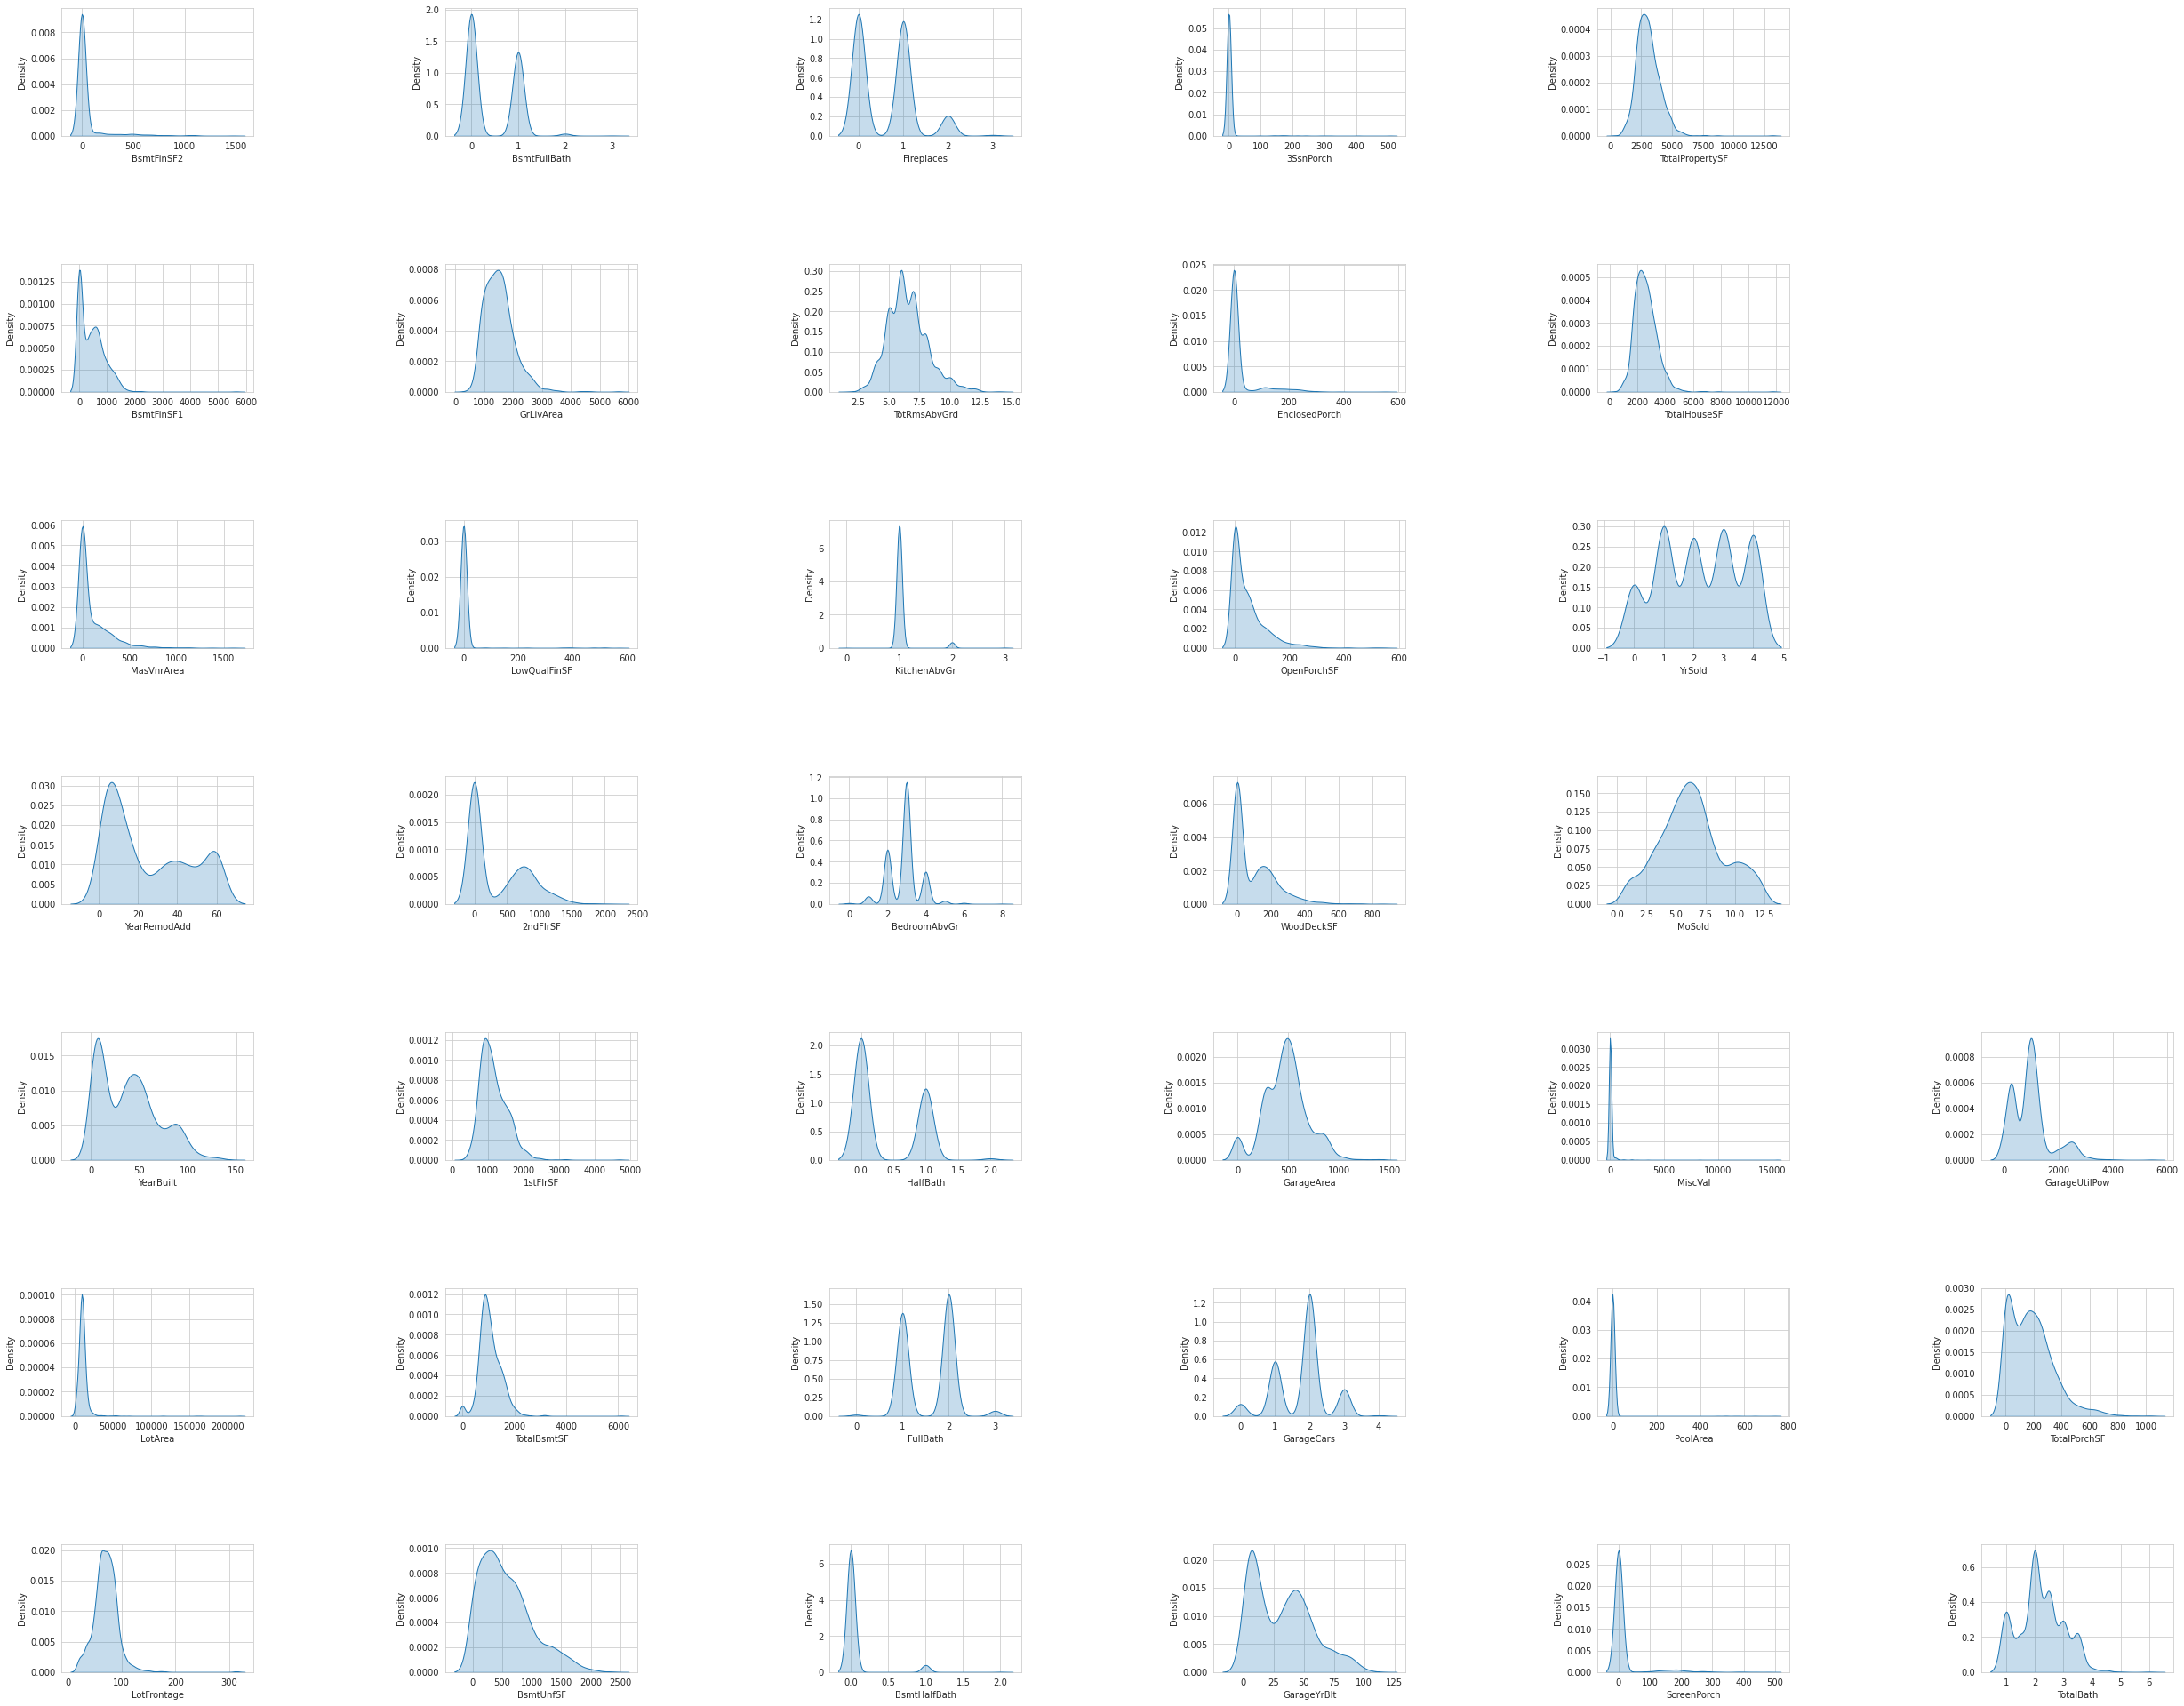

In [45]:
numeric_cols = list(train_numeric.columns.values)
numeric_cols_len = len(numeric_cols)
fig = plt.figure()
ax_cnt = 0
for nc in numeric_cols:
  ax = fig.add_axes([ax_cnt//7, ax_cnt%7, .5, .5])
  sns.kdeplot(x=train_numeric[nc], ax=ax, shade=True)
  ax_cnt += 1

> From the kde plots, we could see some data with high skewness (e.g., OpenPorchSF, YearRemodAdd, etc). The table below shows the numeric values of skewness in descending order.

In [46]:
skewness = train_numeric.apply(lambda x: spst.skew(x.dropna())).sort_values(ascending=False)
skewness_df = pd.DataFrame({'Skewness': skewness})
display(skewness_df[abs(skewness_df['Skewness'])>0.5])

,Skewness
MiscVal,24.451640
PoolArea,14.813135
LotArea,12.195142
3SsnPorch,10.293752
LowQualFinSF,9.002080
KitchenAbvGr,4.483784
BsmtFinSF2,4.250888
ScreenPorch,4.117977
BsmtHalfBath,4.099186
EnclosedPorch,3.086696


> Among several transform methods, we choose yeojohnson transform, which not only performs the best in reducing skewness, but also tolerates with zero values.

In [47]:
log_candidates = skewness_df[abs(skewness)>0.15].index.tolist()
for c in log_candidates:
    train_numeric[c] = spst.yeojohnson(train_numeric[c])[0]
    test_numeric[c] = spst.yeojohnson(test_numeric[c])[0]
skewness = train_numeric.apply(lambda x: spst.skew(x)).sort_values(ascending=False)
skewness_df = pd.DataFrame({'Skewness': skewness})
display(skewness_df[abs(skewness_df['Skewness'])>0.15])

,Skewness
PoolArea,14.337930
3SsnPorch,7.605922
LowQualFinSF,7.291912
MiscVal,5.011373
BsmtHalfBath,3.855436
ScreenPorch,3.110067
BsmtFinSF2,2.423157
EnclosedPorch,2.045836
HalfBath,0.520899
MasVnrArea,0.412657


> We drop features with a still high skewness, for that they are no good to the regression model.


In [48]:
cols_to_drop_due_to_skewness = skewness_df[abs(skewness)>1].index.tolist()
train_numeric.drop(columns=cols_to_drop_due_to_skewness, inplace=True)
test_numeric.drop(columns=cols_to_drop_due_to_skewness, inplace=True)

> A final numeric feature selection will base on the correlation to SalePrice. Before that, we check the distribution of the SalesPrice.
>Again we start with distribution plots. Because now we have only 1 variable to analyze,we could find the best transformation method to normality through finding a well-fitted distribution.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

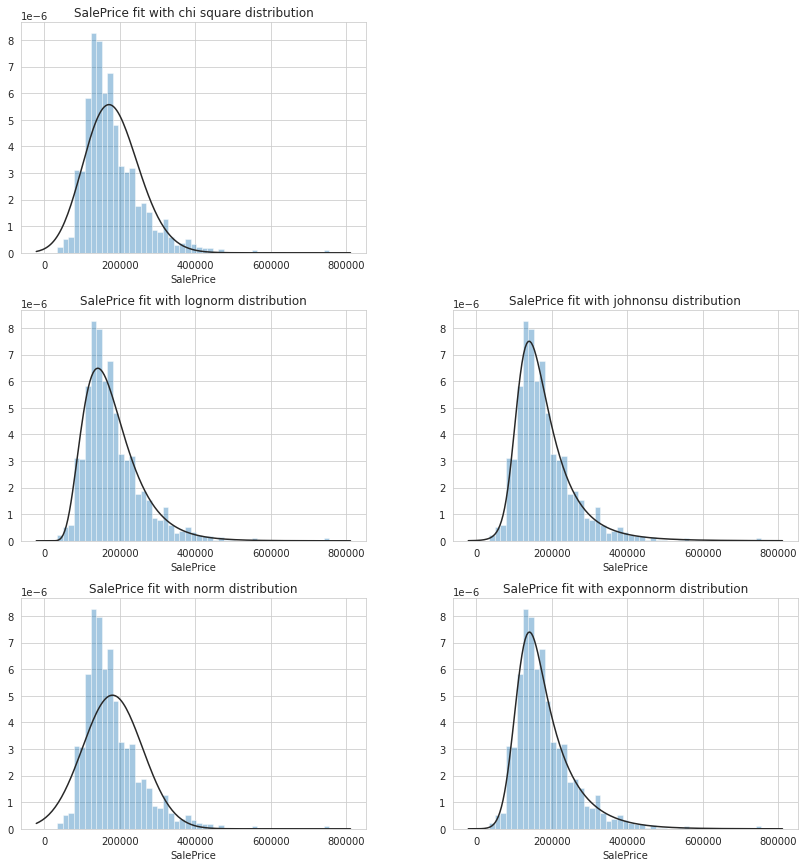

In [49]:
candidate_dist = [spst.norm, spst.lognorm, spst.chi2, spst.exponnorm, spst.johnsonsu]
candidate_dist_name = ['norm', 'lognorm', 'chi square', 'exponnorm', 'johnonsu']
fig = plt.figure()
for i, (d, n) in enumerate(zip(candidate_dist, candidate_dist_name)):
    ax = fig.add_axes([i//3, i%3, .8,.8])
    sns.distplot(train['SalePrice'], kde=False, fit=d).set_title("SalePrice fit with %s distribution" % n, fontsize=12)
    

> In former works, JohnsonSU was found as a well-fit distribution.
In our works, we found that exponentially modified Gaussian distribution would achieve nearly the same effect.
Searched information has shown that it is suitable to transform exponential data sample with Box-Cox transform.
The skewness is satisfactorily reduced to nearly zero

In [50]:
print("Skewness before transformation: %.2f" % spst.skew(train['SalePrice']))
train_Y, ld = spst.boxcox(train['SalePrice'])
print("Skewness before transformation: %.2f" % spst.skew(train_Y))

Skewness before transformation: 1.88
Skewness before transformation: -0.01


> The correlation of the remaining numeric features with transformed SalePrice are as following.

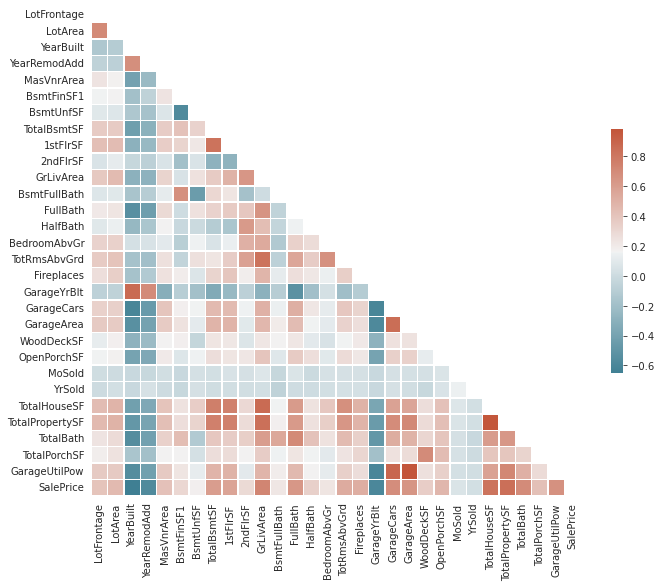

In [51]:
df_numeric_cp = train_numeric.copy()
df_numeric_cp['SalePrice'] = train_Y
numeric_corr = df_numeric_cp.corr(method='spearman')
mask = np.zeros_like(numeric_corr)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 20, as_cmap=True)
fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(numeric_corr, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5})

> We rule out features that has correation lower than a threshold.

In [52]:
low_correlation_cols = []
df_train_Y = pd.DataFrame()
df_train_Y['SalePrice'] = train_Y
for c in list(train_numeric.columns.values):
  if abs(train_numeric[c].corr(df_train_Y['SalePrice']))<0.4:
    low_correlation_cols.append(c)
train_numeric.drop(columns=low_correlation_cols, inplace=True)
test_numeric.drop(columns=low_correlation_cols, inplace=True)

In [53]:
train_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   YearBuilt        1460 non-null   float64
 1   YearRemodAdd     1460 non-null   float64
 2   MasVnrArea       1460 non-null   float64
 3   TotalBsmtSF      1460 non-null   float64
 4   1stFlrSF         1460 non-null   float64
 5   GrLivArea        1460 non-null   float64
 6   FullBath         1460 non-null   int64  
 7   TotRmsAbvGrd     1460 non-null   float64
 8   Fireplaces       1460 non-null   float64
 9   GarageYrBlt      1460 non-null   float64
 10  GarageCars       1460 non-null   float64
 11  GarageArea       1460 non-null   float64
 12  OpenPorchSF      1460 non-null   float64
 13  TotalHouseSF     1460 non-null   float64
 14  TotalPropertySF  1460 non-null   float64
 15  TotalBath        1460 non-null   float64
 16  TotalPorchSF     1460 non-null   float64
 17  GarageUtilPow 

#### **Categorical Features**
###### ***Handling of missing values***
>Categorical values have no avearge or median number, therefore, I will highligt missing values and drop features with too many missing values.



In [54]:
for feature in categorical:
  train[feature] = train[feature].fillna('Missing')

###### ***Primary Feature Selection***

>Considering that there are many categorical features in the dataset and values in a categorical feature are equal. Therefore, I will drop low-distinction features automatically or low correlation with house price manually.

>First, it's the voilin pictures to measure primary correlation. 

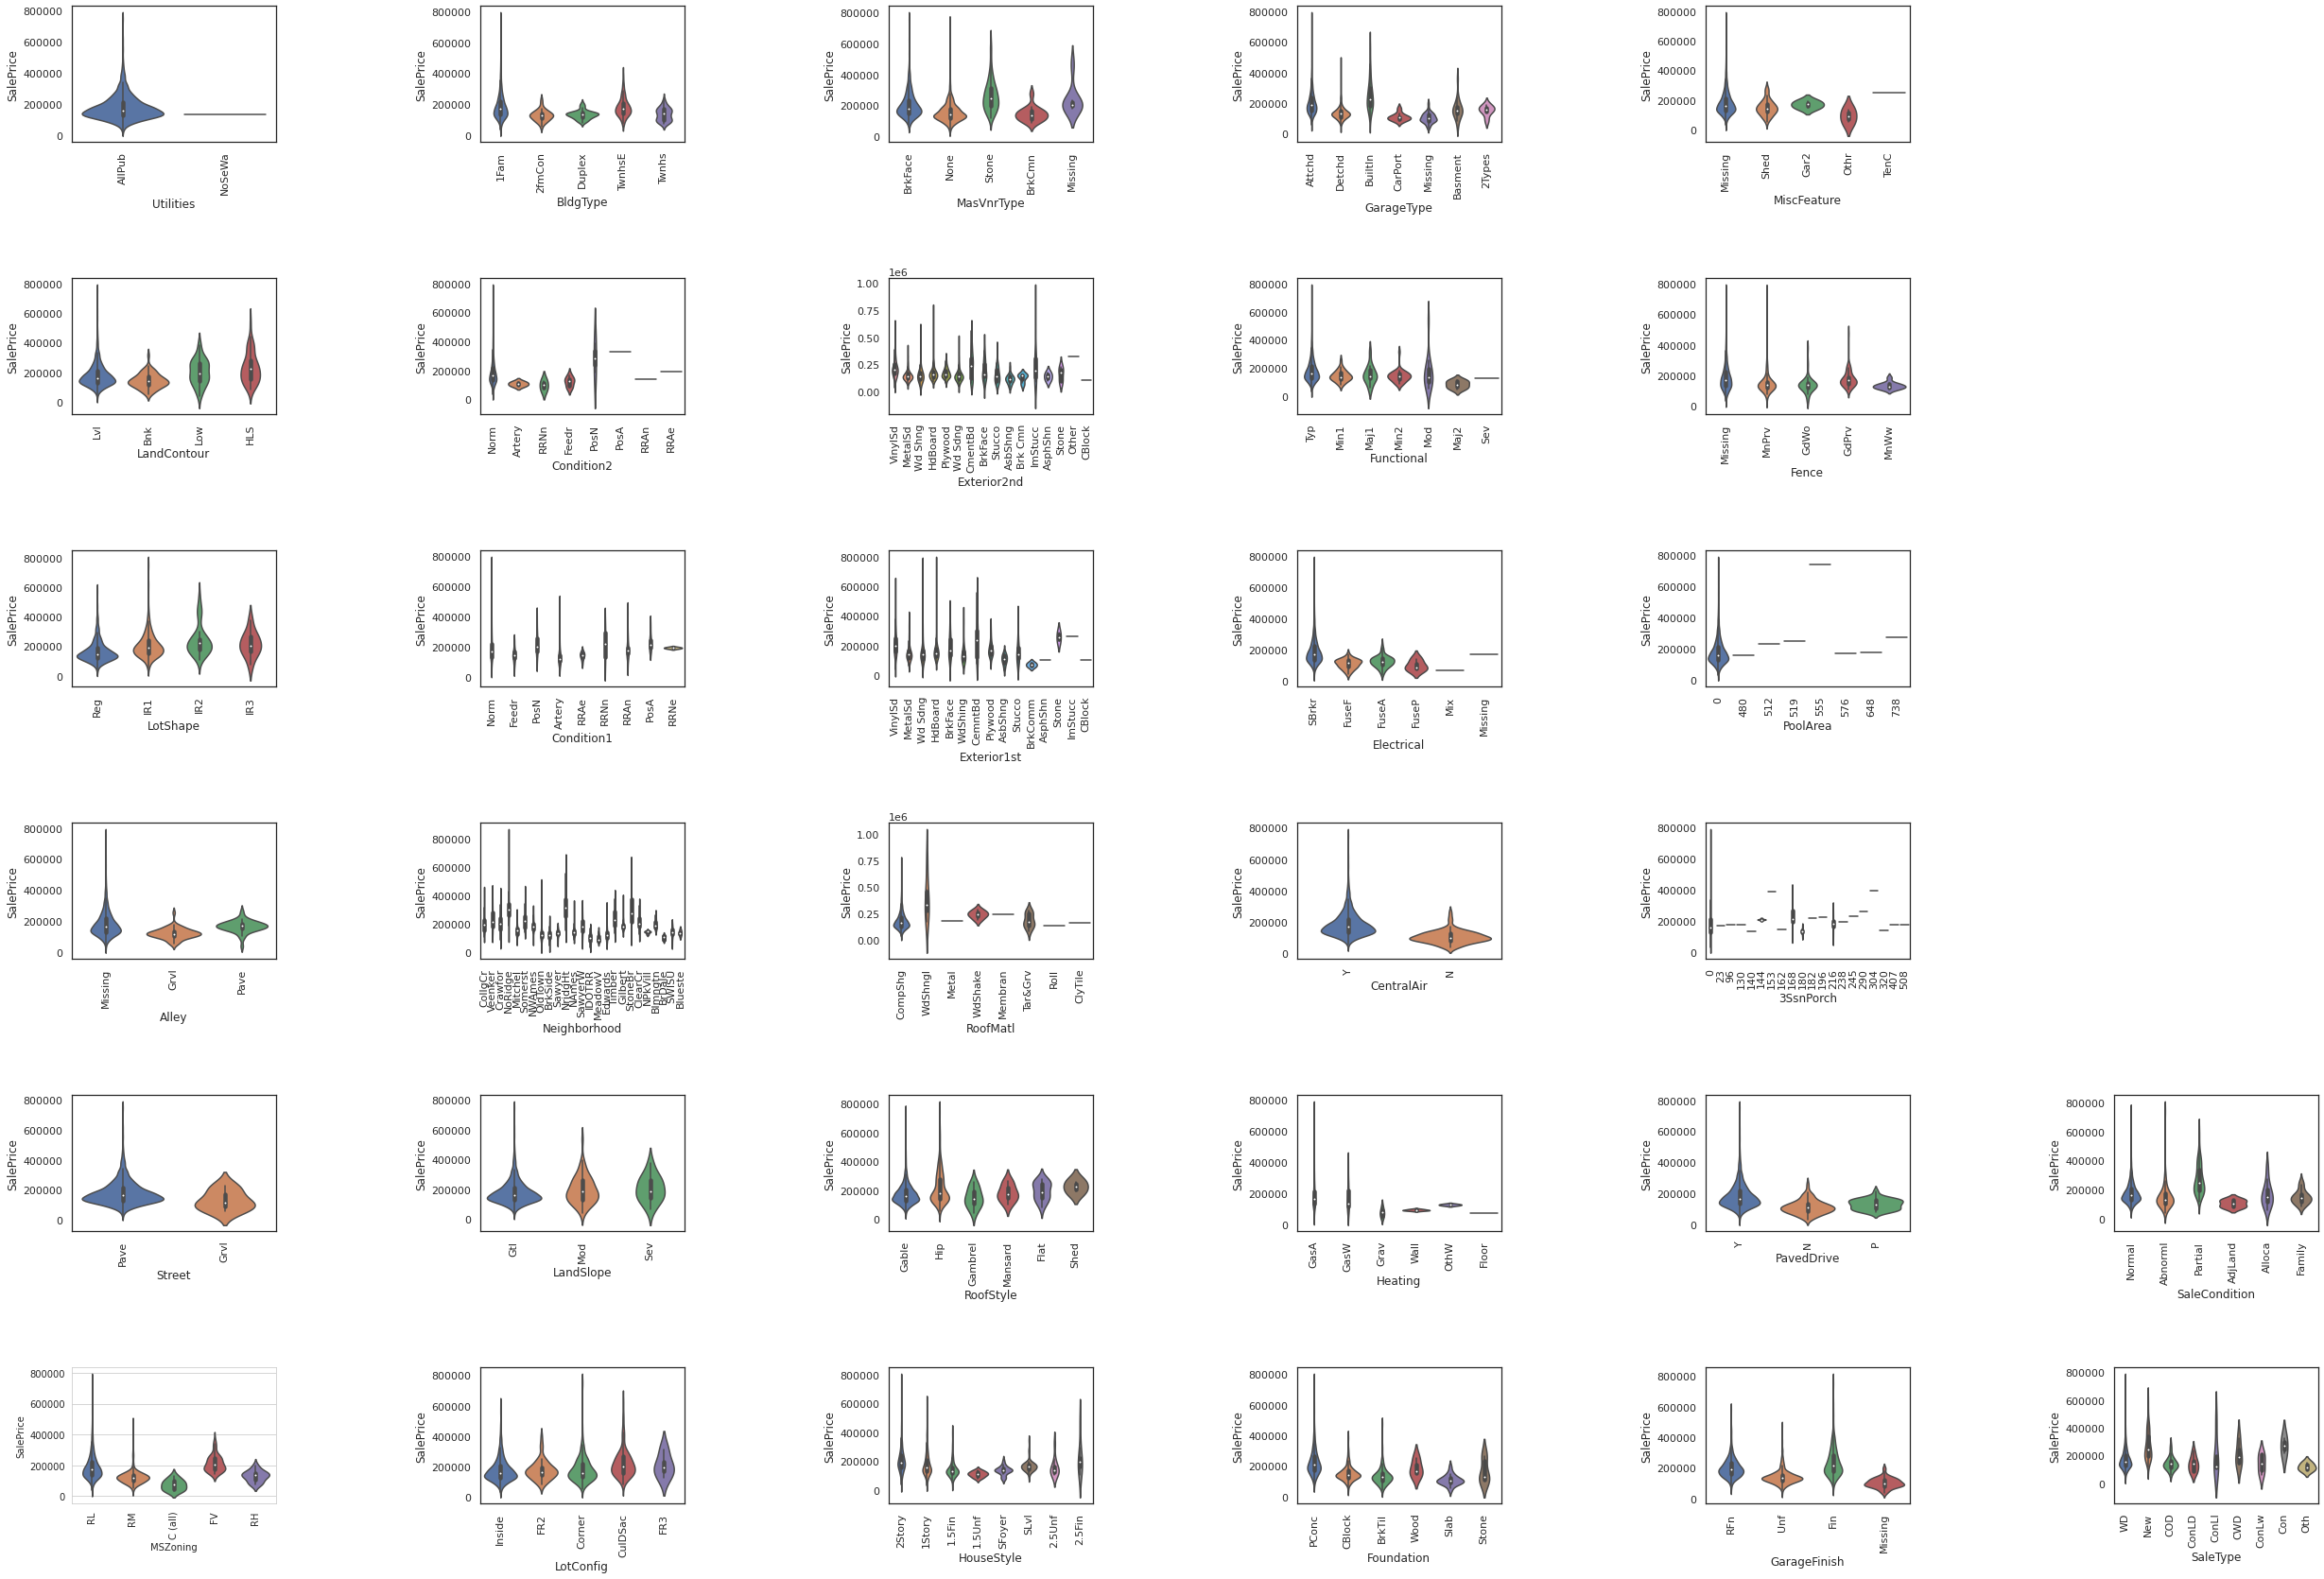

In [55]:
cat_fig = plt.figure()
ax_cnt = 0
for feature in categorical:
  ax = cat_fig.add_axes([ax_cnt//6, ax_cnt%6, .5, .5])
  sns.set(color_codes=True)
  sns.set_style("white")
  plt.xlabel(feature)
  Violin = sns.violinplot(x=train[feature], y=train["SalePrice"])
  plt.setp(Violin.get_xticklabels(), rotation=90)
  ax_cnt += 1

>Secondly, let's check the distinction and number of missing values:

In [56]:
for feature in categorical:
  print('-----------------------------------------')
  print(train[feature].value_counts().max)

-----------------------------------------
<bound method Series.max of RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64>
-----------------------------------------
<bound method Series.max of Pave    1454
Grvl       6
Name: Street, dtype: int64>
-----------------------------------------
<bound method Series.max of Missing    1369
Grvl         50
Pave         41
Name: Alley, dtype: int64>
-----------------------------------------
<bound method Series.max of Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64>
-----------------------------------------
<bound method Series.max of Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64>
-----------------------------------------
<bound method Series.max of AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64>
-----------------------------------------
<bound method Series.max of Inside     1052
Corner      263
CulDSac      94
FR2    

>Based on voilin pictures and statistics to different values for each categorical feature, I will determine whether to drop a feature through three dimension:
>1. If the missing values larger than 20% of total data (1460 * 20% = 292).
>2. If there is any value occupy more than 90% of dataset (1314).
>3. If the correlation to house price is not obvious. (Manually check the violin pictures.)

>Therefore, here are the remaining features which satisfy these three requirements.

In [57]:
categorical = ['MSZoning', 'Neighborhood', 'HouseStyle', 'Exterior1st', 'Exterior2nd', 'Foundation', 'GarageType', 'GarageFinish', 'SaleType', 'SaleCondition']

###### ***Feature Encoding***
>For categorical featrues, the simplist way for encoding may be the one-hot encoding. However, the train dataset is quite small (1460 rows) and some feature may have more than 10 distinct value even with low distinction. Using one-hot coding may cause matrics sparsification and decrease accuracy.

>Therefore, I decide to use 'value-mapping', which means "groupby SalePrice according to one feature and sort it based on mean and median" [1]. This is basically a manual step and different people may give different sort methods for the same feature. 

>Firstly, let's compute median and average SalePrice for all values of each selected feature:


([1] Reference: All You Need is PCA (LB: 0.11421, top 4%), MASSQUANTITY, https://www.kaggle.com/massquantity/all-you-need-is-pca-lb-0-11421-top-4 (2016).)

In [58]:
for feature in categorical:
  print('--------------------------------------------------------------------')    
  print(train.groupby([feature])[['SalePrice']].agg(['mean', 'median', 'count'])) #Reference from [1] for this single group statement.    

--------------------------------------------------------------------
              SalePrice              
                   mean  median count
MSZoning                             
C (all)    74528.000000   74700    10
FV        214014.061538  205950    65
RH        131558.375000  136500    16
RL        191004.994787  174000  1151
RM        126316.830275  120500   218
--------------------------------------------------------------------
                  SalePrice              
                       mean  median count
Neighborhood                             
Blmngtn       194870.882353  191000    17
Blueste       137500.000000  137500     2
BrDale        104493.750000  106000    16
BrkSide       124834.051724  124300    58
ClearCr       212565.428571  200250    28
CollgCr       197965.773333  197200   150
Crawfor       210624.725490  200624    51
Edwards       128219.700000  121750   100
Gilbert       192854.506329  181000    79
IDOTRR        100123.783784  103000    37
MeadowV     

>Now let's map values to label numbers and fill the null values with median:

In [59]:
categorical_train = train.copy()
categorical_train = pd.DataFrame(categorical_train, columns=categorical + ['SalePrice'])
categorical_train = categorical_train.replace('Missing', 0)

def map_for_data():
    categorical_train['MSZoning'] = categorical_train['MSZoning'].map({'FV': 3, 'RL': 3, 'RH': 2, 'RM': 2, 'C (all)': 1})
    categorical_train['Neighborhood'] = categorical_train['Neighborhood'].map({'Blmngtn': 5, 'Blueste': 3, 'BrDale': 1, 'BrkSide': 2, 'ClearCr': 6,
                            'CollgCr': 5, 'Crawfor': 6, 'Edwards': 2, 'Gilbert': 5, 'IDOTRR': 1,
                            'MeadowV': 1, 'Mitchel': 4, 'NAmes': 4, 'NPKVill': 4, 'NWAmes': 5,
                            'NoRidge': 7, 'NridgHt': 7, 'OldTown': 2, 'SWISU': 4, 'Sawyer': 3,
                            'SawyerW': 5, 'Somerst': 6, 'StoneBr': 7, 'Timber': 6, 'Veenker': 6})
    categorical_train['HouseStyle'] = categorical_train['HouseStyle'].map({'2.5Fin': 4, '2Story': 4, '1Story': 3, 'SLvl': 3, '2.5Unf': 2, '1.5Fin': 2,
                          'SFoyer': 2, '1.5Unf': 1})
    categorical_train['Exterior1st'] = categorical_train['Exterior1st'].map({'AsbShng': 2, 'AsphShn': 2, 'BrkComm': 1, 'BrkFace': 5, 'CBlock': 2,
                          'CemntBd': 7, 'HdBoard': 4, 'ImStucc': 8, 'MetalSd': 3, 'Plywood': 5,
                          'Stone': 8, 'Stucco': 4, 'VinylSd': 6, 'Wd Sdng': 3, 'WdShing': 3})
    categorical_train['Exterior2nd'] = categorical_train['Exterior2nd'].map({'AsbShng': 1, 'AsphShn': 1, 'Brk Cmn': 1, 'BrkFace': 3, 'CBlock': 1,
                          'CmentBd': 4, 'HdBoard': 3, 'ImStucc': 4, 'MetalSd': 2, 'Other': 5,
                          'Plywood': 3, 'Stone': 3, 'Stucco': 2, 'VinylSd': 4, 'Wd Sdng': 2, 'Wd Shng': 2})
    categorical_train['Foundation'] = categorical_train['Foundation'].map({'PConc':6, 'Wood': 5, 'Stone': 4, 'CBlock':3, 'BrkTil':2, 'Slab':1})
    categorical_train['GarageType'] = categorical_train['GarageType'].map({'BuiltIn':5, 'Attchd':4, '2Types':3, 'Basment':3, 'Detchd':2, 'CarPort':1})
    categorical_train['GarageFinish'] = categorical_train['GarageFinish'].map({'Fin':2, 'RFn':1, 'Unf':0})
    categorical_train['SaleType'] = categorical_train['SaleType'].map({'New':5, 'Con':5, 'CWD':4, 'ConLI':4, 'WD':3, 'COD':2, 'ConLD':2, 'ConLw':2, 'Oth':1})
    categorical_train['SaleCondition'] = categorical_train['SaleCondition'].map({'Partial':8, 'Normal':5, 'Alloca':4, 'Family':3, 'Abnorml':2, 'AdjLand':1})
map_for_data()
categorical_train = categorical_train.fillna(categorical_train.median())
print(categorical_train)

      MSZoning  Neighborhood  HouseStyle  ...  SaleType  SaleCondition  SalePrice
0            3           5.0           4  ...         3              5     208500
1            3           6.0           3  ...         3              5     181500
2            3           5.0           4  ...         3              5     223500
3            3           6.0           4  ...         3              2     140000
4            3           7.0           4  ...         3              5     250000
...        ...           ...         ...  ...       ...            ...        ...
1455         3           5.0           4  ...         3              5     175000
1456         3           5.0           3  ...         3              5     210000
1457         3           6.0           4  ...         3              5     266500
1458         3           4.0           3  ...         3              5     142125
1459         3           2.0           3  ...         3              5     147500

[1460 rows x 11

###### ***Correlation Calculation***
>Now, I will plot violin pictures for encoded features and calculate their correlation.


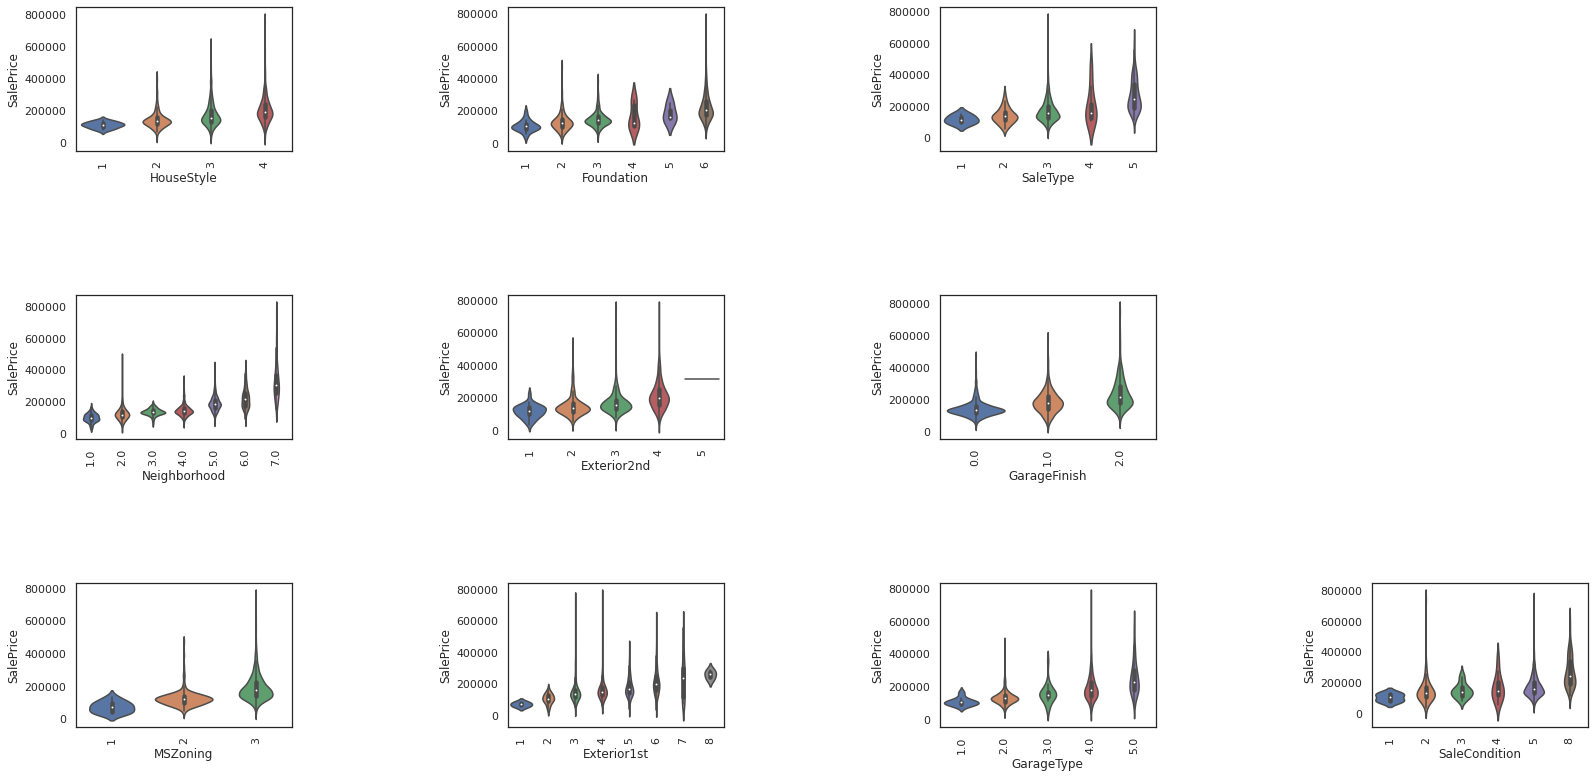

In [60]:
cat_fig = plt.figure()
ax_cnt = 0
for feature in categorical:
  ax = cat_fig.add_axes([ax_cnt//3, ax_cnt%3, .5, .5])
  sns.set(color_codes=True)
  sns.set_style("white")
  plt.xlabel(feature)
  Violin = sns.violinplot(x=categorical_train[feature], y=categorical_train["SalePrice"])
  plt.setp(Violin.get_xticklabels(), rotation=90)
  ax_cnt += 1

In [61]:
from scipy.stats import pointbiserialr
for feature in categorical:
  print(feature, ': ', pointbiserialr(categorical_train[feature], categorical_train['SalePrice']))

MSZoning :  PointbiserialrResult(correlation=0.3221987895999799, pvalue=1.283134900310385e-36)
Neighborhood :  PointbiserialrResult(correlation=0.6701797535279588, pvalue=5.1519941639699525e-191)
HouseStyle :  PointbiserialrResult(correlation=0.2917619253942099, pvalue=4.836529442916937e-30)
Exterior1st :  PointbiserialrResult(correlation=0.3846074438932704, pvalue=1.1282124736903266e-52)
Exterior2nd :  PointbiserialrResult(correlation=0.37607757234755024, pvalue=2.9094682641835423e-50)
Foundation :  PointbiserialrResult(correlation=0.5055031712897448, pvalue=1.550746357476438e-95)
GarageType :  PointbiserialrResult(correlation=0.402803120549104, pvalue=4.6095857912866875e-58)
GarageFinish :  PointbiserialrResult(correlation=0.48275441091028953, pvalue=4.263006940106301e-86)
SaleType :  PointbiserialrResult(correlation=0.3664118358581532, pvalue=1.2896178151245787e-47)
SaleCondition :  PointbiserialrResult(correlation=0.3332971035340395, pvalue=3.260018512245069e-39)


>At last, we will use features with a correlation higher than 0.35.

In [62]:
final_categorical = ['Neighborhood', 'Exterior1st', 'Exterior2nd', 'Foundation', 'GarageType', 'GarageFinish', 'SaleType']
categorical_train = pd.DataFrame(categorical_train, columns=final_categorical)
print(categorical_train.median()) # Used to switch missing values in test dataset.
print(categorical_train)

Neighborhood    5.0
Exterior1st     5.0
Exterior2nd     3.0
Foundation      3.0
GarageType      4.0
GarageFinish    1.0
SaleType        3.0
dtype: float64
      Neighborhood  Exterior1st  ...  GarageFinish  SaleType
0              5.0            6  ...           1.0         3
1              6.0            3  ...           1.0         3
2              5.0            6  ...           1.0         3
3              6.0            3  ...           0.0         3
4              7.0            6  ...           1.0         3
...            ...          ...  ...           ...       ...
1455           5.0            6  ...           1.0         3
1456           5.0            5  ...           0.0         3
1457           6.0            7  ...           1.0         3
1458           4.0            3  ...           0.0         3
1459           2.0            4  ...           2.0         3

[1460 rows x 7 columns]


>Generation of test sets:

In [63]:
categorical_test = test.copy()
categorical_test = pd.DataFrame(categorical_test, columns=final_categorical)

def map_for_test_data():
    categorical_test['Neighborhood'] = categorical_test['Neighborhood'].map({'Blmngtn': 5, 'Blueste': 3, 'BrDale': 1, 'BrkSide': 2, 'ClearCr': 6,
                            'CollgCr': 5, 'Crawfor': 6, 'Edwards': 2, 'Gilbert': 5, 'IDOTRR': 1,
                            'MeadowV': 1, 'Mitchel': 4, 'NAmes': 4, 'NPKVill': 4, 'NWAmes': 5,
                            'NoRidge': 7, 'NridgHt': 7, 'OldTown': 2, 'SWISU': 4, 'Sawyer': 3,
                            'SawyerW': 5, 'Somerst': 6, 'StoneBr': 7, 'Timber': 6, 'Veenker': 6})
    categorical_test['Exterior1st'] = categorical_test['Exterior1st'].map({'AsbShng': 2, 'AsphShn': 2, 'BrkComm': 1, 'BrkFace': 5, 'CBlock': 2,
                          'CemntBd': 7, 'HdBoard': 4, 'ImStucc': 8, 'MetalSd': 3, 'Plywood': 5,
                          'Stone': 8, 'Stucco': 4, 'VinylSd': 6, 'Wd Sdng': 3, 'WdShing': 3})
    categorical_test['Exterior2nd'] = categorical_test['Exterior2nd'].map({'AsbShng': 1, 'AsphShn': 1, 'Brk Cmn': 1, 'BrkFace': 3, 'CBlock': 1,
                          'CmentBd': 4, 'HdBoard': 3, 'ImStucc': 4, 'MetalSd': 2, 'Other': 5,
                          'Plywood': 3, 'Stone': 3, 'Stucco': 2, 'VinylSd': 4, 'Wd Sdng': 2, 'Wd Shng': 2})
    categorical_test['Foundation'] = categorical_test['Foundation'].map({'PConc':6, 'Wood': 5, 'Stone': 4, 'CBlock':3, 'BrkTil':2, 'Slab':1})
    categorical_test['GarageType'] = categorical_test['GarageType'].map({'BuiltIn':5, 'Attchd':4, '2Types':3, 'Basment':3, 'Detchd':2, 'CarPort':1})
    categorical_test['GarageFinish'] = categorical_test['GarageFinish'].map({'Fin':2, 'RFn':1, 'Unf':0})
    categorical_test['SaleType'] = categorical_test['SaleType'].map({'New':5, 'Con':5, 'CWD':4, 'ConLI':4, 'WD':3, 'COD':2, 'ConLD':2, 'ConLw':2, 'Oth':1})
map_for_test_data()

for feature in final_categorical:
  categorical_test[feature] = categorical_test[feature].fillna(categorical_train[feature].median())
print(categorical_test)

      Neighborhood  Exterior1st  ...  GarageFinish  SaleType
0              4.0          6.0  ...           0.0       3.0
1              4.0          3.0  ...           0.0       3.0
2              5.0          6.0  ...           2.0       3.0
3              5.0          6.0  ...           2.0       3.0
4              7.0          4.0  ...           1.0       3.0
...            ...          ...  ...           ...       ...
1454           1.0          7.0  ...           1.0       3.0
1455           1.0          7.0  ...           0.0       3.0
1456           4.0          6.0  ...           0.0       3.0
1457           4.0          4.0  ...           1.0       3.0
1458           4.0          4.0  ...           2.0       3.0

[1459 rows x 7 columns]


#### **Ordinal Features**

###### ***Introduction***
Ordinal features are very similar to the categorical features, but they have minor difference. In ordinal features, **there exist information about rank, which could be represented by quantitive attributes.** For example, 



1. Ex	Excellent
2. Gd	Good
3. TA	Average/Typical
4. Fa	Fair
5. Po	Poor

In this example, Ex and Gd represent different level of an attribute. Thus, in the following section, we will first select all the useful ordinal features and then adopt label encoding, where a higher numeric value refers to a higher rank.

##### ***Encoding***

In [64]:
def ordinal_to_numerical(train, item):
    if item in ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", \
                "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "PoolQC"]:
        train[item] = train[item].map({"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0})
    elif item in ["BsmtExposure"]:
        train[item] = train[item].map({"Gd": 4, "Av": 3, "Mn": 2, "No": 1, "NA": 0})
    elif item in ["BsmtFinType1", "BsmtFinType2"]:
        train[item] = train[item].map({"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1, "NA": 0})
    elif item in ["OverallQual", "OverallCond"]:
        pass
    elif item in ["MSSubClass"]:
        # will go back to this part after finish the analysis
        pass
    else:
        print("{} is not a ordinal feature.".format(item))

In [65]:
ordinal = ["MSSubClass", "OverallQual", "OverallCond", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "PoolQC", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]
train_ordinal = pd.DataFrame(train, columns=ordinal + ["SalePrice"])
print(train_ordinal.head())

   MSSubClass  OverallQual  OverallCond  ... BsmtFinType1 BsmtFinType2 SalePrice
0          60            7            5  ...          GLQ          Unf    208500
1          20            6            8  ...          ALQ          Unf    181500
2          60            7            5  ...          GLQ          Unf    223500
3          70            7            5  ...          ALQ          Unf    140000
4          60            8            5  ...          GLQ          Unf    250000

[5 rows x 17 columns]


In [66]:
for item in ordinal:
    ordinal_to_numerical(train_ordinal, item)

print(train_ordinal.head())

   MSSubClass  OverallQual  OverallCond  ...  BsmtFinType1  BsmtFinType2  SalePrice
0          60            7            5  ...           6.0           1.0     208500
1          20            6            8  ...           5.0           1.0     181500
2          60            7            5  ...           6.0           1.0     223500
3          70            7            5  ...           5.0           1.0     140000
4          60            8            5  ...           6.0           1.0     250000

[5 rows x 17 columns]


###### ***Feature selection*** 


From all the features, we can find that the following are ordinal features. The total number is 16.

In [67]:
ordinal = ["MSSubClass", "OverallQual", "OverallCond", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "PoolQC", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]

In [68]:
print(len(ordinal))

16


In terms of the meaning they denote, these 16 characteristics can be divided into the following categories.


* The type of dwelling: "MSSubClass", 
* Overall quality and condition: "OverallQual", "OverallCond", 
* Exter quality and condition: "ExterQual", "ExterCond", 
* Basement related features: "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"
* Heating quality and condition: "HeatingQC", 
* Kitching quality: "KitchenQual", 
* Fireplace quality: "FireplaceQu", 
* Garage quality and condition: "GarageQual", "GarageCond", 
* Pool quality and condition: "PoolQC"



In [69]:
train_ordinal.isnull().sum()

MSSubClass         0
OverallQual        0
OverallCond        0
ExterQual          0
ExterCond          0
BsmtQual          37
BsmtCond          37
HeatingQC          0
KitchenQual        0
FireplaceQu      690
GarageQual        81
GarageCond        81
PoolQC          1453
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
SalePrice          0
dtype: int64

The type of dwelling: "MSSubClass",

In [70]:
train.groupby(['MSSubClass'])[['SalePrice']].agg(['mean','median','count'])


SalePrice              
                     mean  median count
MSSubClass                             
20          185224.811567  159250   536
30           95829.724638   99900    69
40          156125.000000  142500     4
45          108591.666667  107500    12
50          143302.972222  132000   144
60          239948.501672  215200   299
70          166772.416667  156000    60
75          192437.500000  163500    16
80          169736.551724  166500    58
85          147810.000000  140750    20
90          133541.076923  135980    52
120         200779.080460  192000    87
160         138647.380952  146000    63
180         102300.000000   88500    10
190         129613.333333  128250    30

Overall quality and condition: "OverallQual", "OverallCond",

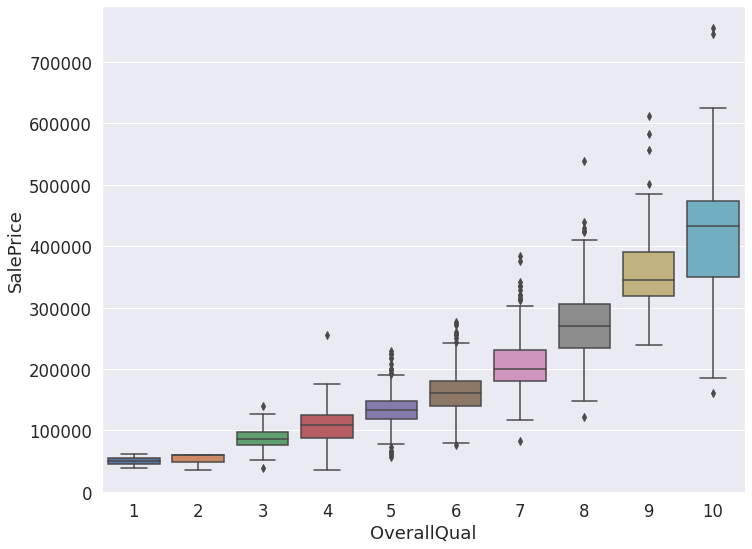

In [71]:
fig = plt.figure(figsize=(20, 15))
sns.set(font_scale=1.5)

# (Corr= 0.817185) Box plot overallqual/salePrice
fig1 = fig.add_subplot(221); sns.boxplot(x='OverallQual', y='SalePrice', data=train[['SalePrice', 'OverallQual']])

plt.tight_layout(); plt.show()

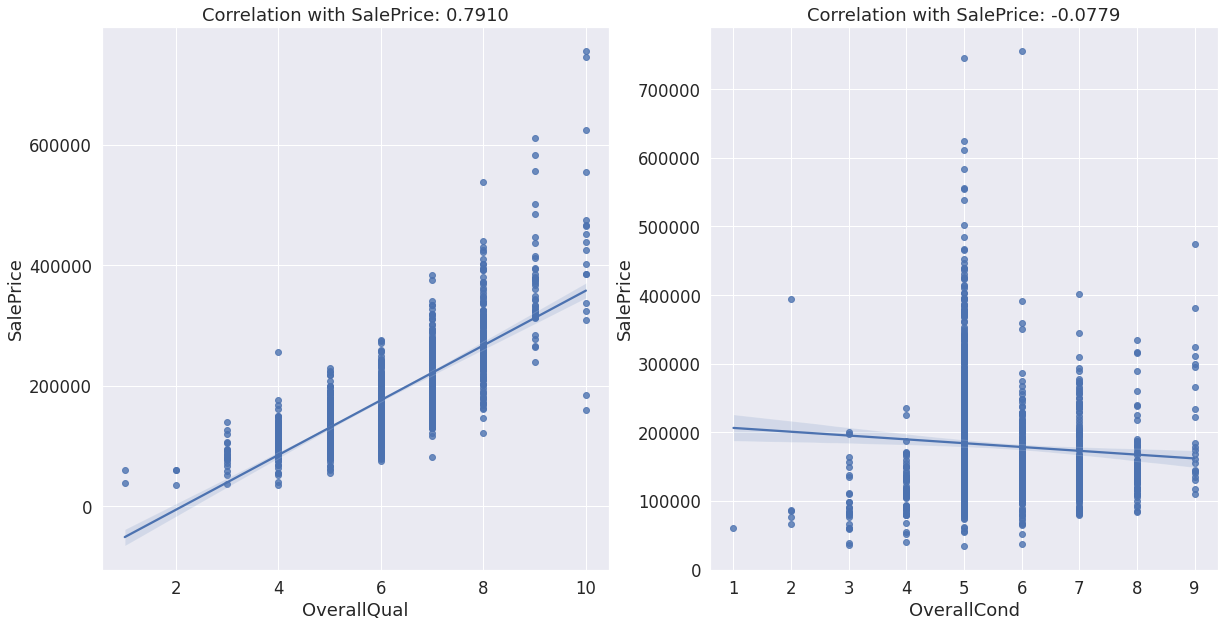

In [72]:
fig = plt.figure(figsize=(20,10))
fig1 = fig.add_subplot(121); sns.regplot(x='OverallQual', y='SalePrice', data=train)
plt.title('Correlation with SalePrice: {:6.4f}'.format(train.OverallQual.corr(train['SalePrice'])))

fig2 = fig.add_subplot(122); sns.regplot(x='OverallCond', y='SalePrice', data=train);
plt.title('Correlation with SalePrice: {:6.4f}'.format(train.OverallCond.corr(train['SalePrice'])))

plt.show()


Exter quality and condition: "ExterQual", "ExterCond",

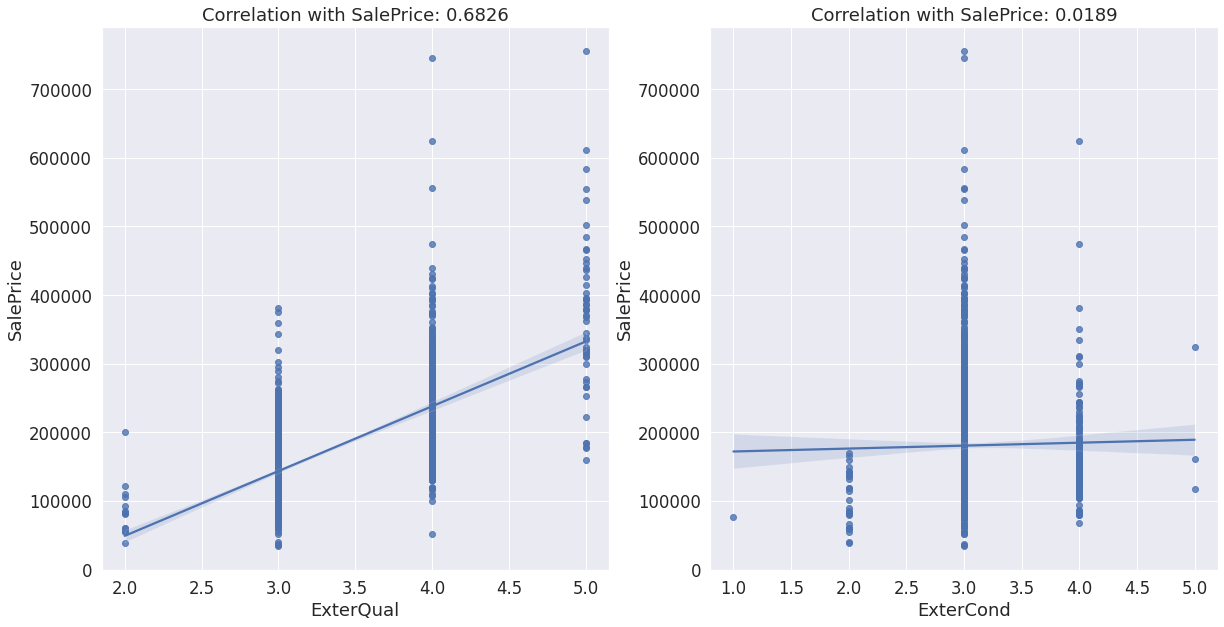

In [73]:
fig = plt.figure(figsize=(20,10))

fig3 = fig.add_subplot(121); sns.regplot(x='ExterQual', y='SalePrice', data=train_ordinal)
plt.title('Correlation with SalePrice: {:6.4f}'.format(train_ordinal.ExterQual.corr(train_ordinal['SalePrice'])))

fig4 = fig.add_subplot(122); sns.regplot(x='ExterCond', y='SalePrice', data=train_ordinal)
plt.title('Correlation with SalePrice: {:6.4f}'.format(train_ordinal.ExterCond.corr(train_ordinal['SalePrice'])))

plt.show()


Basement related features: "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"

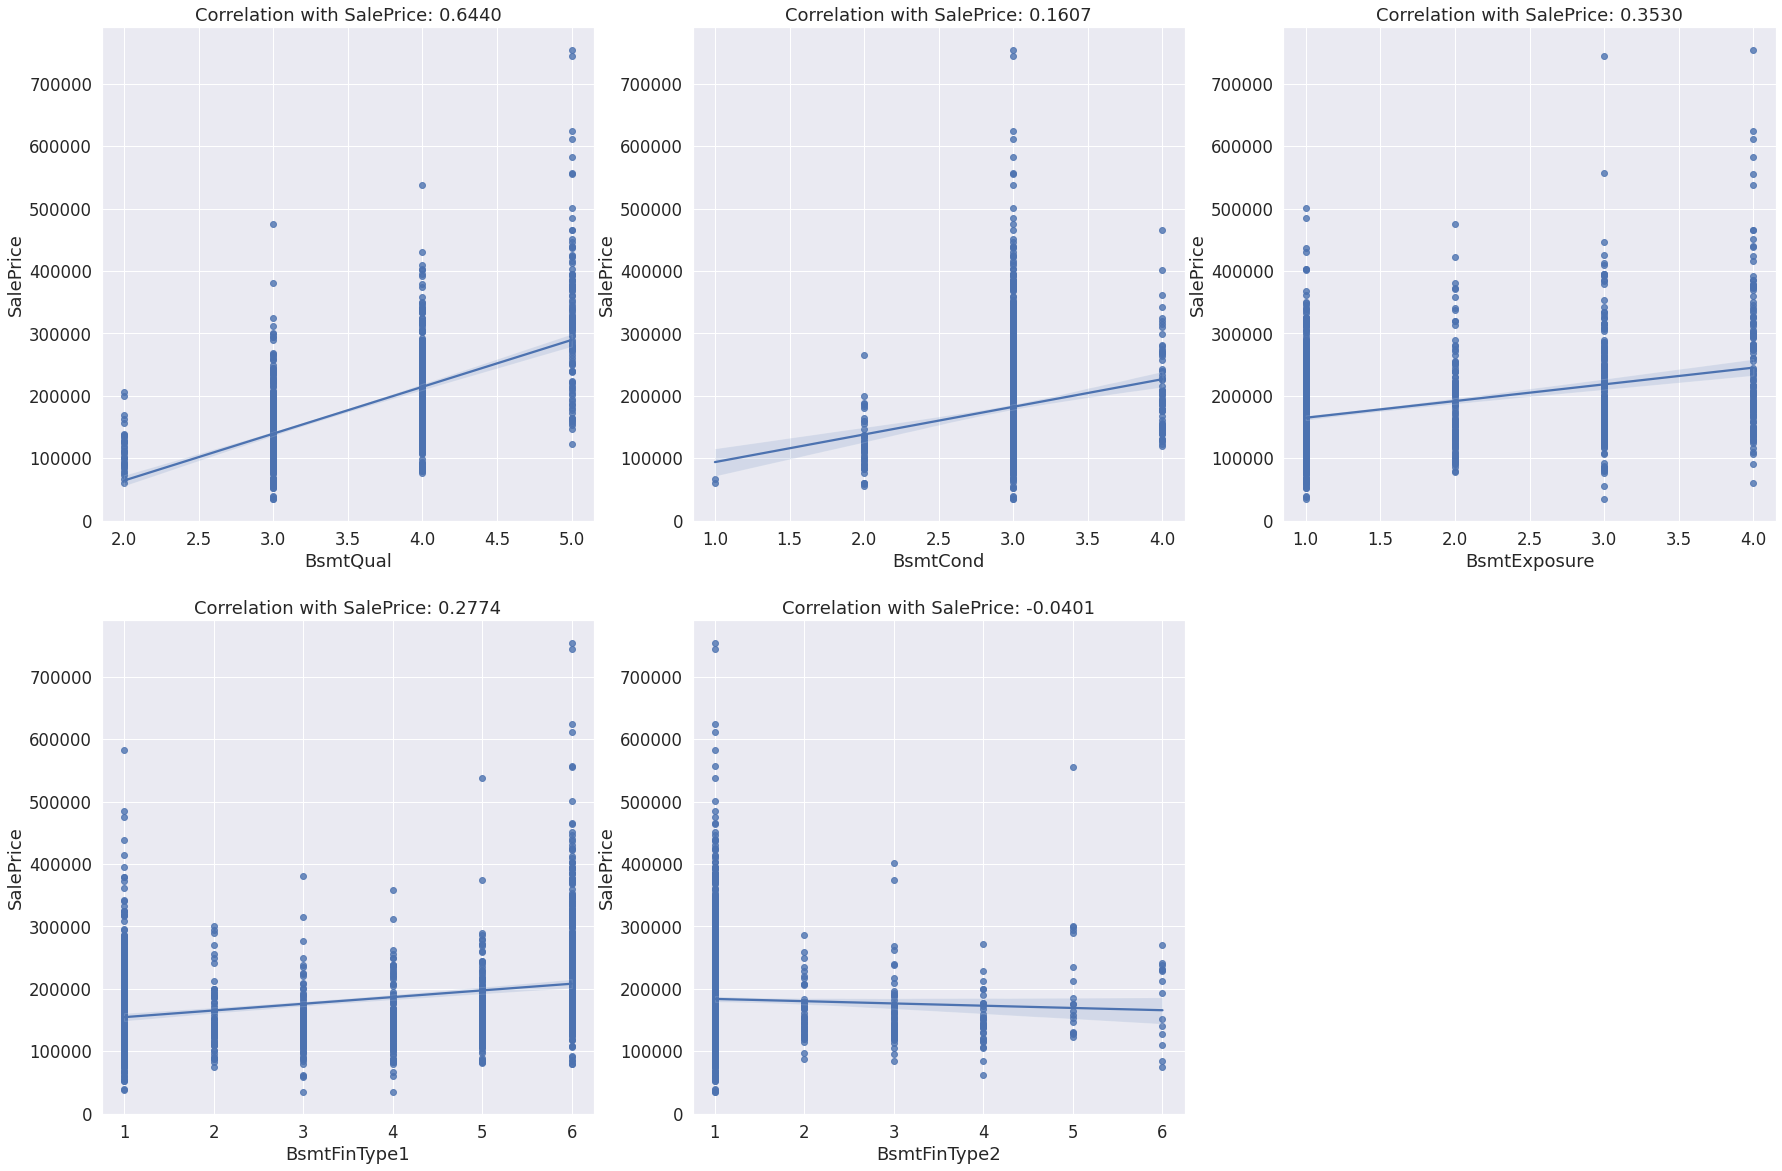

In [74]:
fig = plt.figure(figsize=(30,20))
fig1 = fig.add_subplot(231); sns.regplot(x='BsmtQual', y='SalePrice', data=train_ordinal)
plt.title('Correlation with SalePrice: {:6.4f}'.format(train_ordinal.BsmtQual.corr(train_ordinal['SalePrice'])))

fig2 = fig.add_subplot(232); sns.regplot(x='BsmtCond', y='SalePrice', data=train_ordinal);
plt.title('Correlation with SalePrice: {:6.4f}'.format(train_ordinal.BsmtCond.corr(train_ordinal['SalePrice'])))

fig3 = fig.add_subplot(233); sns.regplot(x='BsmtExposure', y='SalePrice', data=train_ordinal)
plt.title('Correlation with SalePrice: {:6.4f}'.format(train_ordinal.BsmtExposure.corr(train_ordinal['SalePrice'])))

fig4 = fig.add_subplot(234); sns.regplot(x='BsmtFinType1', y='SalePrice', data=train_ordinal);
plt.title('Correlation with SalePrice: {:6.4f}'.format(train_ordinal.BsmtFinType1.corr(train_ordinal['SalePrice'])))

fig5 = fig.add_subplot(235); sns.regplot(x='BsmtFinType2', y='SalePrice', data=train_ordinal)
plt.title('Correlation with SalePrice: {:6.4f}'.format(train_ordinal.BsmtFinType2.corr(train_ordinal['SalePrice'])))

plt.show()

Heating quality and condition: "HeatingQC",

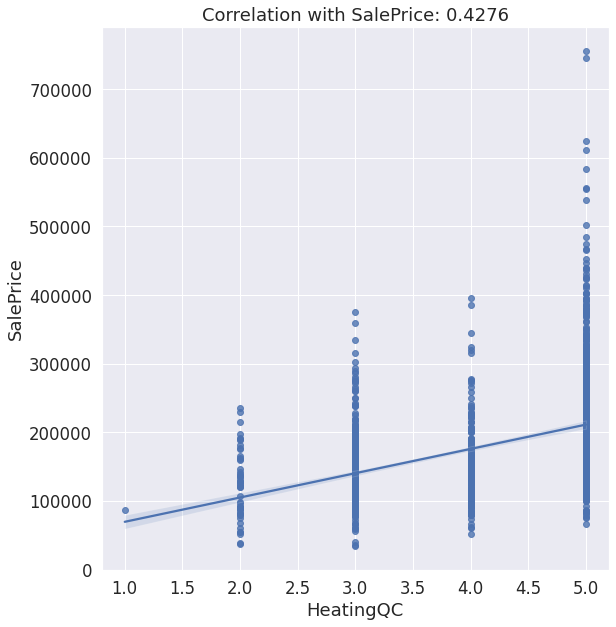

In [75]:
fig = plt.figure(figsize=(20,10))

fig4 = fig.add_subplot(121); sns.regplot(x='HeatingQC', y='SalePrice', data=train_ordinal)
plt.title('Correlation with SalePrice: {:6.4f}'.format(train_ordinal.HeatingQC.corr(train_ordinal['SalePrice'])))

plt.show()

Kitching quality: "KitchenQual",

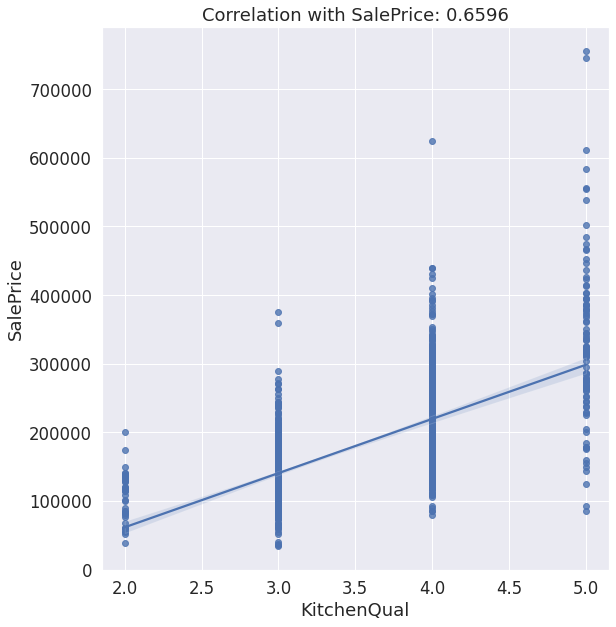

In [76]:
fig = plt.figure(figsize=(20,10))

fig4 = fig.add_subplot(121); sns.regplot(x='KitchenQual', y='SalePrice', data=train_ordinal)
plt.title('Correlation with SalePrice: {:6.4f}'.format(train_ordinal.KitchenQual.corr(train_ordinal['SalePrice'])))

plt.show()

Fireplace quality: "FireplaceQu",

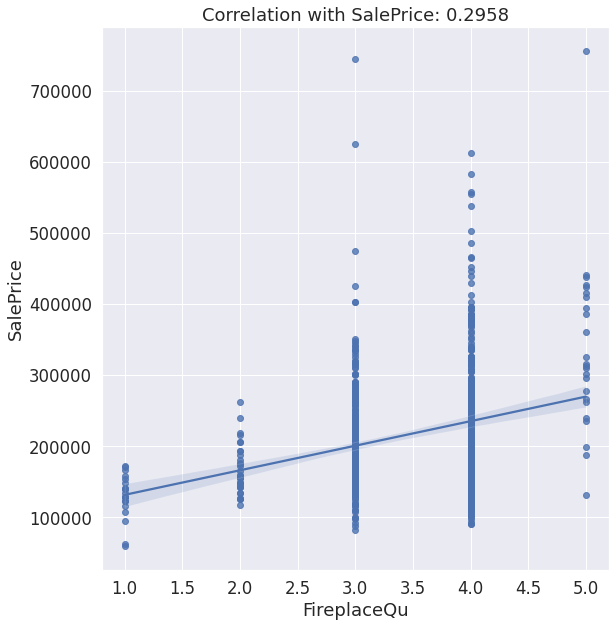

In [77]:
fig = plt.figure(figsize=(20,10))

fig4 = fig.add_subplot(121); sns.regplot(x='FireplaceQu', y='SalePrice', data=train_ordinal)
plt.title('Correlation with SalePrice: {:6.4f}'.format(train_ordinal.FireplaceQu.corr(train_ordinal['SalePrice'])))

plt.show()

Garage quality and condition: "GarageQual", "GarageCond",

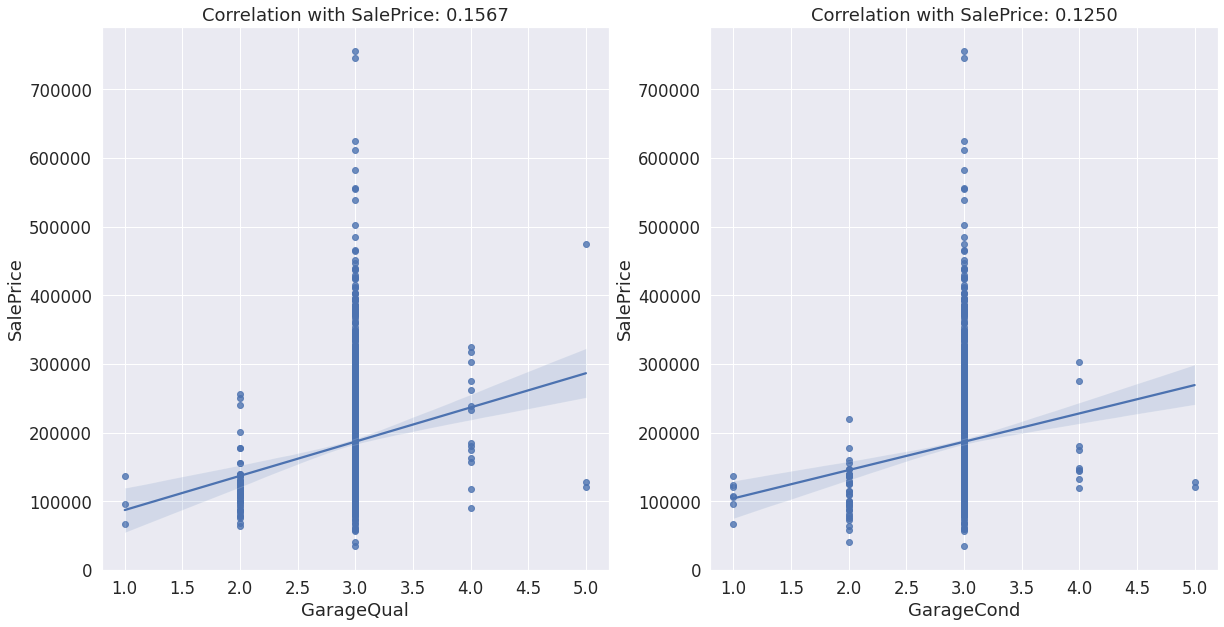

In [78]:
fig = plt.figure(figsize=(20,10))

fig4 = fig.add_subplot(121); sns.regplot(x='GarageQual', y='SalePrice', data=train_ordinal)
plt.title('Correlation with SalePrice: {:6.4f}'.format(train_ordinal.GarageQual.corr(train_ordinal['SalePrice'])))

fig5 = fig.add_subplot(122); sns.regplot(x='GarageCond', y='SalePrice', data=train_ordinal)
plt.title('Correlation with SalePrice: {:6.4f}'.format(train_ordinal.GarageCond.corr(train_ordinal['SalePrice'])))

plt.show()

Pool quality and condition: "PoolQC": As we discussed previously, we will not use this one because it have 99% null value.

According to the above analysis, if we set the correlation threshold to be 0.3, we will finally get the following oridinal features in the first round feature engineering. We may refine it slightly in the iterative feature engineering round.

In [79]:
ordinal = ["MSSubClass", "OverallQual",  "ExterQual", "BsmtQual", "HeatingQC", "KitchenQual", "BsmtExposure"]

In [80]:
def ordinal_to_numerical(train, item):
    if item in ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", \
                "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "PoolQC"]:
        train[item] = train[item].map({"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0})
    elif item in ["BsmtExposure"]:
        train[item] = train[item].map({"Gd": 4, "Av": 3, "Mn": 2, "No": 1, "NA": 0})
    elif item in ["BsmtFinType1", "BsmtFinType2"]:
        train[item] = train[item].map({"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1, "NA": 0})
    elif item in ["OverallQual", "OverallCond"]:
        pass
    elif item in ["MSSubClass"]:
        train[item] = train[item].astype(str)
        train[item] = train[item].map({'180':1, '30':2, '45':2, '190':3, '50':3, '90':3, '85':4, '40':4, '160':4, '70':5, '20':5, '75':5, '80':5, '150':5, '120': 6, '60':6})
    else:
        print("{} is not a ordinal feature.".format(item))

In [81]:
train_ordinal = pd.DataFrame(train, columns=ordinal + ["SalePrice"])
print(train_ordinal.head())
train_ordinal["KitchenQual"].fillna("TA", inplace=True)
train_ordinal["BsmtExposure"].fillna('NA',  inplace=True)
train_ordinal["BsmtQual"].fillna('NA',  inplace=True)
for item in ordinal:
    ordinal_to_numerical(train_ordinal, item)
train_ordinal.info()

   MSSubClass  OverallQual ExterQual  ... KitchenQual BsmtExposure SalePrice
0          60            7        Gd  ...          Gd           No    208500
1          20            6        TA  ...          TA           Gd    181500
2          60            7        Gd  ...          Gd           Mn    223500
3          70            7        TA  ...          Gd           No    140000
4          60            8        Gd  ...          Gd           Av    250000

[5 rows x 8 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   MSSubClass    1460 non-null   int64
 1   OverallQual   1460 non-null   int64
 2   ExterQual     1460 non-null   int64
 3   BsmtQual      1460 non-null   int64
 4   HeatingQC     1460 non-null   int64
 5   KitchenQual   1460 non-null   int64
 6   BsmtExposure  1460 non-null   int64
 7   SalePrice     1460 non-null   int64


In [82]:
test_ordinal = pd.DataFrame(test, columns=ordinal)
test_ordinal.isnull().sum()
test_ordinal["KitchenQual"].fillna("TA", inplace=True)
test_ordinal["BsmtExposure"].fillna('NA', inplace=True)
test_ordinal["BsmtQual"].fillna('NA', inplace=True)
test_ordinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MSSubClass    1459 non-null   int64 
 1   OverallQual   1459 non-null   int64 
 2   ExterQual     1459 non-null   object
 3   BsmtQual      1459 non-null   object
 4   HeatingQC     1459 non-null   object
 5   KitchenQual   1459 non-null   object
 6   BsmtExposure  1459 non-null   object
dtypes: int64(2), object(5)
memory usage: 79.9+ KB


In [83]:
print(test_ordinal.head())
for item in ordinal:
    ordinal_to_numerical(test_ordinal, item)
print(test_ordinal.head())

   MSSubClass  OverallQual ExterQual  ... HeatingQC KitchenQual BsmtExposure
0          20            5        TA  ...        TA          TA           No
1          20            6        TA  ...        TA          Gd           No
2          60            5        TA  ...        Gd          TA           No
3          60            6        TA  ...        Ex          Gd           No
4         120            8        Gd  ...        Ex          Gd           No

[5 rows x 7 columns]
   MSSubClass  OverallQual  ExterQual  ...  HeatingQC  KitchenQual  BsmtExposure
0           5            5          3  ...          3            3             1
1           5            6          3  ...          3            4             1
2           6            5          3  ...          4            3             1
3           6            6          3  ...          5            4             1
4           6            8          4  ...          5            4             1

[5 rows x 7 columns]


#### **Modification and Integration**

In [84]:
train_ordinal.drop(columns=['SalePrice'], inplace=True)

> Within iterative development and comparison with existing works, we found that one-hot encoding will receive lower RMSLE than label encoding on categorical data. Thus, we push the one-hot encoded categorical features to the training set.

> The training set consists of the numeric features, binary features including one-hot encoded features and existence signs, and ordinal label features.

In [85]:
train_ordinal = train_ordinal.apply(np.log1p)
test_ordinal = test_ordinal.apply(np.log1p)

all_cat = pd.concat([categorical_train.astype(int), categorical_test.astype(int)], ignore_index=True).astype(str)
all_cat = pd.get_dummies(all_cat)

train_X = pd.concat([train_numeric, train_existance, all_cat[:train.shape[0]], train_ordinal], axis=1)
sub = all_cat[train.shape[0]:]
sub.index = test_numeric.index
test_X = pd.concat([test_numeric, test_existance, sub, test_ordinal], axis=1)


#### **Principal component analysis (PCA)**
> In practical terms, PCA is used for reducing both the feature dimension and multicolinearity between features.

###### ***Standardization*** 
> What PCA do is to project original data onto dimensions which maximize the variance. The procedure of PCA determines that the data passed to PCA process have to be normalized. A robust scaler, who 'removes the median and scales the data according to the quantile range', is namely robust to the outliers in training data. We have observed at least some outliers of numeric data in the EDA part, and a robust scaler would deal with it effortlessly though not perfectly.

In [86]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

###### ***PCA*** 

In [87]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95)
train_X_settled = pca.fit_transform(train_X_scaled)
test_X_settled = pca.transform(test_X_scaled)
print(pca.explained_variance_ratio_)

"""train_X_settled = train_X_scaled
test_X_settled = test_X_scaled"""

[0.39453899 0.08227684 0.06887321 0.06391582 0.04468814 0.03980922
 0.03024182 0.0272628  0.02180623 0.01987083 0.01677482 0.01584075
 0.01448984 0.01195512 0.01121761 0.0097518  0.00931824 0.00863175
 0.00820676 0.00766873 0.00732222 0.00720197 0.00677213 0.00618787
 0.00585339 0.00552514 0.00506318]


'train_X_settled = train_X_scaled\ntest_X_settled = test_X_scaled'

# **Model Comparison**

#### **Evaluation**
> According to the competition description, Root Mean Squared Logaritmic error (RMSLE) is used as evaluation metric. We here define a cross validation tool that simplify the later model evaluation.

In [88]:
from sklearn.model_selection import cross_val_score, GridSearchCV
def cv_rmse(model,X,Y):
    rmse = np.sqrt(-cross_val_score(model, X, Y, scoring="neg_mean_squared_log_error", cv=5))
    return rmse

#### **Single Models**

In [89]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, BayesianRidge, SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.svm import SVR, LinearSVR
from scipy.special import inv_boxcox
from sklearn.metrics import mean_squared_log_error

> We select 8 models that we have been familar with in the former study. By cross validation, we could compare the performances of models. 

In [90]:
from sklearn.base import clone
models = [LinearRegression(),Ridge(alpha=0.5,max_iter=5000),Lasso(alpha=0.5,max_iter=5000),RandomForestRegressor(),GradientBoostingRegressor(),
          ElasticNet(alpha=0.001,max_iter=5000),SGDRegressor(max_iter=1000,tol=1e-3),XGBRegressor()]
names = ["LR", "Ridge", "Lasso", "RF", "GBR", "Ela","SGD","Xgb"]
for name, model in zip(names, models):
    score = cv_rmse(model, train_X_settled, train_Y)
    print("%s: RMLSE mean = %.5f, RMLSE std = %.4f" % (name,score.mean(),score.std()))

LR: RMLSE mean = 0.00680, RMLSE std = 0.0004
Ridge: RMLSE mean = 0.00680, RMLSE std = 0.0004
Lasso: RMLSE mean = 0.01790, RMLSE std = 0.0007
RF: RMLSE mean = 0.00708, RMLSE std = 0.0003
GBR: RMLSE mean = 0.00671, RMLSE std = 0.0004
Ela: RMLSE mean = 0.00679, RMLSE std = 0.0004
SGD: RMLSE mean = 0.00713, RMLSE std = 0.0006
[13:46:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:46:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:46:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:46:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:46:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Xgb: RMLSE mean = 0.00667, RMLSE std = 0.

> The result of cross validation does not show huge differences among most of the regression models. However we could observe that the L2 regularization process in Lasso regressor seems to best attenuate the overfitting problem. 

> It has to be admitted that the cross validation results are still far lower than the prediction RMLSE shown in Kaggle community. We hypothetically consider on of the reason of this condition to be the insufficiency of training data.

In [91]:
def to_submission(prediction, filename=None):
  res = inv_boxcox(prediction, ld)
  df_predict_Y = pd.read_csv('sample_submission.csv')
  df_predict_Y['SalePrice'] = res
  df_predict_Y.to_csv(('submission.csv' if filename is None else filename), index=False)
  return df_predict_Y
for model, name in zip(models, names):
  model_cp = model
  model_cp.fit(train_X_settled, train_Y)
  res = model_cp.predict(test_X_settled)
  res = to_submission(res, filename=(name+'_pred.csv'))

[13:46:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


> With a paramter grid, theoretically we could find the most suitable paramters for the models

In [92]:
class grid(): # An open source effective parameter grid test class by Massquantity from https://github.com/massquantity/
    def __init__(self,model):
        self.model = model
    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error")
        grid_search.fit(X,y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])
grid(Ridge()).grid_get(train_X_settled, train_Y,{'alpha':[35,40,45,50,55,60,65,70,80,90]})
grid(ElasticNet()).grid_get(train_X_settled, train_Y,{'alpha':[0.0005,0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3,0.5,0.7],'max_iter':[10000]})

{'alpha': 35} 0.059828706630286714
          params  mean_test_score  std_test_score
0  {'alpha': 35}         0.059829        0.000501
1  {'alpha': 40}         0.059830        0.000503
2  {'alpha': 45}         0.059834        0.000504
3  {'alpha': 50}         0.059841        0.000505
4  {'alpha': 55}         0.059851        0.000505
5  {'alpha': 60}         0.059863        0.000506
6  {'alpha': 65}         0.059877        0.000507
7  {'alpha': 70}         0.059893        0.000508
8  {'alpha': 80}         0.059929        0.000509
9  {'alpha': 90}         0.059971        0.000510
{'alpha': 0.004, 'l1_ratio': 0.08, 'max_iter': 10000} 0.0599024009865118
                                               params  ...  std_test_score
0   {'alpha': 0.0005, 'l1_ratio': 0.08, 'max_iter'...  ...        0.000492
1   {'alpha': 0.0005, 'l1_ratio': 0.1, 'max_iter':...  ...        0.000493
2   {'alpha': 0.0005, 'l1_ratio': 0.3, 'max_iter':...  ...        0.000498
3   {'alpha': 0.0005, 'l1_ratio': 0.5, 'ma

In [94]:
els =ElasticNet(alpha=0.0001,max_iter=1500)
els.fit(train_X_settled, train_Y)
res = els.predict(test_X_settled)
res = to_submission(res, filename='ela.csv')

In [95]:
ridge = Ridge(alpha=35,max_iter=10000)
ridge.fit(train_X_settled, train_Y)
res = ridge.predict(test_X_settled)
res = to_submission(res, filename='ridge.csv')

###### **Wrapper Method: Feature Elimination**
> Besides PCA as a feature selection approach, we could utilize wrapper methods to eliminate features. A recursive feature elimination model has been implemented in Scikit-Learn, which removes the 'unimportant'
 features based on the coef attribute or feature importances gained from designated model. In the experiment with Elastic Net and Ridge Regression, we found that Ela's performance is largely degraded while Ridge remains nearly the same performance as orinigal features.

In [96]:
from sklearn.feature_selection import RFE
def wrapper_feature_elimination(estimator, model, name):
    selector = RFE(estimator=estimator, n_features_to_select=15)
    new_train_X = selector.fit_transform(train_X_settled, train_Y)
    new_test_X = selector.transform(test_X_settled)
    model.fit(new_train_X, train_Y)
    res = model.predict(new_test_X)
    res = to_submission(res, filename=(name+'_pred.csv'))
for model, name in zip([ElasticNet(), Ridge()], ['Ela', 'Ridge']):
  wrapper_feature_elimination(clone(model), clone(model), name)

#RMSLE = 0.41630780091952574 and 0.14906394754227914

#### **A glimpse into Blend Model**
> Blend model is usually a effortless and beneficial method to improve the model performance. In this case, however, this voting method just has a slight improvement than single regression models. We assume that it stems from the high similarity among the working strategies of the regression models used, which makes bad or good predictions happen at same time.

In [97]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
class blend():
  def __init__(self):
    self.blend_models = [LinearRegression(),Ridge(alpha=0.5,max_iter=5000),
            ElasticNet(alpha=0.001,max_iter=10000),SGDRegressor(max_iter=1000,tol=1e-3)]
    self.names = ["LR", "Ridge","Ela","SGD","Xgb"]

  def fit(self, X=None, y=None):
    for bm in self.blend_models:
      bm.fit(X, y)
  
  def predict(self, X=None):
    ress = np.zeros(X.shape[0])
    for bm in self.blend_models:
      bm.predict(X)
      ress += bm.predict(X)
    return (ress/len(self.blend_models))

kf=KFold(n_splits=5, random_state=None, shuffle=False)
rmsle_sum=0
count=0
for train_index, test_index in kf.split(train_X_settled):
  X_train, X_test = train_X_settled[train_index], train_X_settled[test_index]
  y_train, y_test = train_Y[train_index], train_Y[test_index]
  bmodel = blend()
  bmodel.fit(X_train, y_train)
  rmsle_sum+=mean_squared_log_error(y_test, bmodel.predict(X_test))
  count+=1
print("RMSLE of blend model: %.5f" % (rmsle_sum/count))
bmodel = blend()
bmodel.fit(train_X_settled, train_Y)
res = bmodel.predict(test_X_settled)
res = to_submission(res) #RMSLE 0.1482 in submission


RMSLE of blend model: 0.00005


# **Observations and Conclusion**
> We have conducted a comprehensive excavation through the house pricing dataset and applied detailed feature engineering approachs. We have utilized highly reasonable missing value filling methods, the encoding methods, normalization methods based on distribution attributes including distribution types and skewness, correlationship analysing and novel feature creation process.

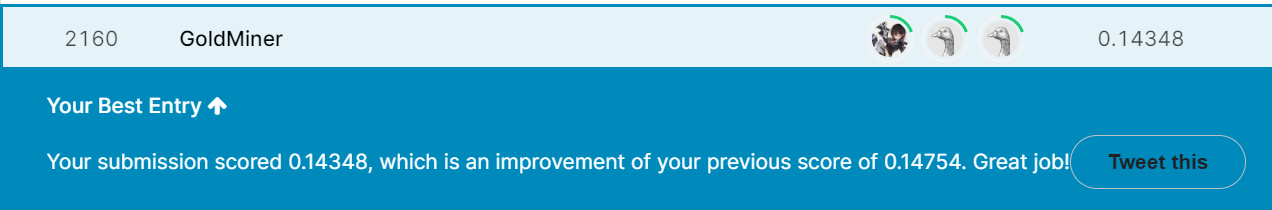
> We have obtained 2160th position in the competition. Although theoretically PCA should perform an important role in the model in most situations, the Elastic Net model happens to out perform the other models when there's no PCA process. It may reveal some features of Elastic Net models that differ them from traditional regularization models, which is very attracting for us to further explore in.
